# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; 
# add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, auc, roc_auc_score, confusion_matrix , precision_recall_curve

import xgboost as xgb
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit 

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

pd.set_option("display.max_columns", None)

# Part 0: Get to Know the Data

## Data Background

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Data Dictionary

In [3]:
def fill_na(df, col):
    '''
    Fill in the blank cell with the last valid observation
    
    Keyword arguments:
    df: dataframe
    col: column name
    
    Returns:
    dataframe with filled value
    
    '''
    df[col].fillna(method = 'ffill', inplace = True)
    return df

In [4]:
#read in feature spreadsheet, these two sheets are multi-level indexed, so use fill_na function to fill the blank cells
attributes_describe = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx',header = 1, usecols = range(1,5))
attributes_describe = fill_na(attributes_describe, 'Information level')

feature_info = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header = 1, usecols = range(1,6))
feature_info = fill_na(feature_info, 'Attribute')
feature_info = fill_na(feature_info, 'Description')

In [5]:
feature_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [6]:
feature_info.Attribute.nunique(), feature_info.Description.nunique()

(314, 316)

In [7]:
attributes_describe.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [8]:
attributes_describe.Attribute.nunique(), attributes_describe['Information level'].nunique()

(313, 10)

In [9]:
set(feature_info.Attribute) - set(attributes_describe.Attribute)

{'BIP_FLAG',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_LOTTO_RZ',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'KBA13_CCM_3000',
 'KBA13_CCM_3001'}

## Read

In [10]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/home/yusuf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [12]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

In [13]:
data = azdias.copy()

## Pre-processing

### Cleaning: D19 Columns

In columns starts with 'D19_', For '**no transaction known**', it is filled with 0 or 10. To bring sanity, we will replace all the 10 with 0s for all the columns.

In [14]:
def replace_d19_10_with_0(data):
    
    d19_columns = [i for i in data.columns if i.startswith('D19')]
    data[d19_columns] = data[d19_columns].replace(10, 0)
    
    return data

In [15]:
data = replace_d19_10_with_0(data)

### Replacing all unknowns with NULL

In [16]:
def replace_with_nan(data):
    
#     Replace 'X' with NAN. Also convert that into float to avoid having 2 different values for the same value
#     CAMEO_DEUG_2015: CAMEO classification 2015 - Uppergroup
    CAMEO_DEUG_2015_map = {'X': np.nan }
    data['CAMEO_DEUG_2015'] = data['CAMEO_DEUG_2015'].replace(CAMEO_DEUG_2015_map).astype(float)
    
    # As we see there are lot of unknown values which is saved with null
    data = data.replace(-1, np.nan)
    
    return data

In [17]:
data = replace_with_nan(data)

### Encode object column type 

There are 5 columns which are object types. Since, 3 of these 5 are not available in data dictionary and have lot of categories to perform one-hot encoding, we will drop them:

**Object type columns:** 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'
       
**Drop columns:** 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'

**Encoding Columns:** 'CAMEO_DEU_2015', 'OST_WEST_KZ'

In [18]:
object_cols = data.select_dtypes(['object'])
object_cols.columns

Index(['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
       'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [19]:
data.describe(include=["object", "bool"])

,CAMEO_DEU_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,792242,792242,634108,798073,798073
unique,45,43,35,5162,2
top,6B,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,56672,77576,195338,383738,629528


In [20]:
# CAMEO_DEU_2015: New German CAMEO Typology established together with Call Credit in late 2015
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [21]:
def encode_columns(data):
#     PRAEGENDE_JUGENDJAHRE: dominating movement in the person's youth (avantgarde or mainstream)
#     This feature contains 2 informations i.e. decade and movement

    PRAEGENDE_JUGENDJAHRE_map = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    data['PRAEGENDE_JUGENDJAHRE_decade'] = data['PRAEGENDE_JUGENDJAHRE'].replace(PRAEGENDE_JUGENDJAHRE_map)

    PRAEGENDE_JUGENDJAHRE_map = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    data['PRAEGENDE_JUGENDJAHRE_movement'] = data['PRAEGENDE_JUGENDJAHRE'].replace(PRAEGENDE_JUGENDJAHRE_map)    
    
    
    #===================================#
#     OST_WEST_KZ: flag indicating the former GDR/FRG
#     Since OST_WEST_KZ has only 2 unique values, we convert that into boolean

    OST_WEST_KZ_map = {'W':0, 'O':1}
    data['OST_WEST_KZ'] = data['OST_WEST_KZ'].replace(OST_WEST_KZ_map)
    
    #===================================#
    
    data['CAMEO_DEU_2015']  = data['CAMEO_DEU_2015'].replace('XX', np.nan)

    data['CAMEO_DEU_2015_wealth'] = data.CAMEO_DEU_2015[data.CAMEO_DEU_2015.notnull()].map(lambda x: str(x)[0])
    data['CAMEO_DEU_2015_wealth'] = data['CAMEO_DEU_2015_wealth'].astype(float)


    data['CAMEO_DEU_2015_life_stage'] = data.CAMEO_DEU_2015[data.CAMEO_DEU_2015.notnull()].map(lambda x: str(x)[1])

    CAMEO_DEU_2015_life_stage_map = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6}
    data['CAMEO_DEU_2015_life_stage'] = data['CAMEO_DEU_2015_life_stage'].replace(CAMEO_DEU_2015_life_stage_map)
    
    #===================================#
    
    data['CAMEO_INTL_2015'] = data['CAMEO_INTL_2015'].replace({'XX': np.nan}).astype(float)

    data['CAMEO_INTL_2015_wealth'] = data.CAMEO_INTL_2015[data.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[0])
    data['CAMEO_INTL_2015_wealth'] = data['CAMEO_INTL_2015_wealth'].astype(float)

    data['CAMEO_INTL_2015_life_stage'] = data.CAMEO_INTL_2015[data.CAMEO_INTL_2015.notnull()].map(lambda x: str(x)[1])
    data['CAMEO_INTL_2015_life_stage'] = data['CAMEO_INTL_2015_life_stage'].astype(float)
    
    #===================================#
   
    # Drop the extra columns
    data.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1, inplace=True)
    
    return data

# data = encode_columns(data)

In [22]:
def preprocess_data(data):
    
    data = replace_d19_10_with_0(data)
    data = replace_with_nan(data)
    data = encode_columns(data)
    
    return data

data = preprocess_data(azdias)

In [23]:
def remove_majority_null_columns(data):
    na_counts = data.isnull().sum()

    na_counts_DF = pd.DataFrame({'feature':data.columns.values,
                                 'na_counts':na_counts.values, 
                                 'na_percentage': na_counts.values/data.shape[0]})

    na_counts_DF.sort_values(by = 'na_percentage', ascending = False, inplace=True)
    
    # Remove columns having high percentage of nulls
    # Removing columns having more than 25% as nulls

    majority_null_columns  = na_counts_DF[na_counts_DF['na_percentage'] > 0.25]['feature'].values
    print('Number of columns having more than 25% as nulls: ', len(majority_null_columns))

    data = data.drop(majority_null_columns, axis=1)
    
    return majority_null_columns, data

majority_null_columns, data = remove_majority_null_columns(data)

Number of columns having more than 25% as nulls:  16


# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

This part will contain the analysis of customer attributes and compare it with the general population. We concatenate the dataset of customers with the general populations and perform clustering on the whole dataset. Here are the steps:
1. Join both the base i.e customer and general population.
2. Pre-process the data which we discussed in the previous section.
3. Remove the extra columns present in the customer dataset.
4. Find the optimum K using elbow method and silhouette analysis.
5. Apply k-means clustering on the whole combined base
6. Cluster analysis.

Idea is to find the clusters where maximum existing customers exist. Our main objective is to identify customers from the general population who have similar behavior and demographics to the existing customers of the company.

Since we have around 300 features,there are 2 options.

1. Perform PCA on the data and then cluster the principal components. The issue with this approach is we will lose some information and interpretability would become a concern. Moreover, even after reducing the dimensions(features), we will still have a lot of features.
2. To overcome the issues that exist in the previous step, we will go directly with the clustering since 300 features are not really a very high dimension.


## Data Preparation

In [24]:
azdias_data = preprocess_data(azdias)
customers_data = preprocess_data(customers)

In [25]:
# Concatenate the customer population and generic population to perform clustering on the top
cluster_df = pd.concat([azdias, customers[azdias.columns]], ignore_index=True)

In [26]:
azdias.shape, customers.shape, cluster_df.shape

((891221, 366), (191652, 369), (1082873, 366))

In [27]:
cluster_df = preprocess_data(cluster_df)

## Remove Null rows/columns

In [28]:
# Identify and remove missing columns and rows
# Here we are removing all the columns which have more than 25% missing values.
# We will also remove rows which have more than 50% missing values.

# Removing rows having more than 50% nulls

row_null = cluster_df.isnull().sum(axis=1)
row_null_percent = row_null /  cluster_df.shape[1] * 100
null_rows_to_dropped = row_null_percent[row_null_percent>50].index

print('Count of dropped rows ', len(null_rows_to_dropped))

# Removing columns having more than 25% nulls

col_null = cluster_df.isnull().sum(axis=0)
col_null_percent = col_null / len(cluster_df) * 100
null_cols_to_dropped = cluster_df.columns[col_null_percent > 25]

print('Count of dropped columns ', len(null_cols_to_dropped))


Count of dropped rows  149986
Count of dropped columns  16


In [29]:
# Removing Year column as it is not going to add value directly

cluster_df.drop('MIN_GEBAEUDEJAHR', axis=1, inplace=True)

In [30]:
cluster_df.drop(null_cols_to_dropped, axis=1, inplace=True)
cluster_df.drop(null_rows_to_dropped, axis=0, inplace=True)

<AxesSubplot:>

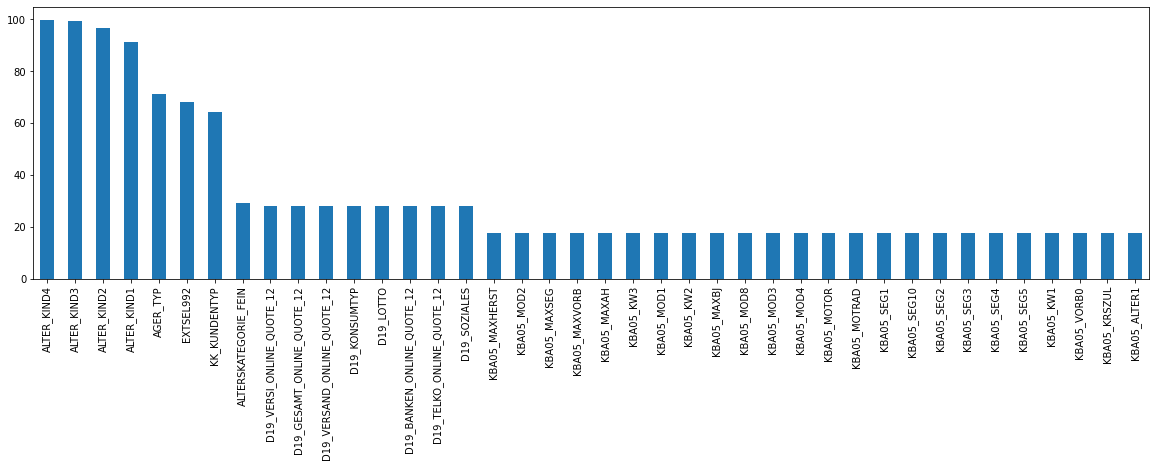

In [31]:
# missing columns
col_null_percent.sort_values(ascending=False)[:40].plot(kind='bar', figsize=(20,5), fontsize=10)

## Impute Nulls

In [32]:
# To impute missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

In [33]:
cluster_df.head()

,LNR,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA1

In [34]:
# Since first column is ID, we will not consider that while preparing data for clustering
filled_cluster_df = imputer.fit_transform(cluster_df.iloc[:,1:])
filled_cluster_df = pd.DataFrame(filled_cluster_df)
print('imputed cluster_df: ', filled_cluster_df.head(2))

imputed cluster_df:     0     1     2    3    4    5     6    7    8    9    10   11   12   13   \
0  9.0   0.0  11.0  0.0  0.0  2.0  12.0  0.0  3.0  6.0  8.0  5.0  1.0  5.0   
1  9.0  17.0  10.0  0.0  0.0  1.0   7.0  0.0  3.0  2.0  4.0  3.0  2.0  4.0   

   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   \
0  5.0  2.0  3.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  4.0  1.0  3.0  2.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   \
0  0.0  0.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  8.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  6.0  6.0  0.0  0.0  0.0   

   59   60   61   62 

## Scale the data

In [35]:
# Scaling the data set before clustering
scaler = StandardScaler()
filled_cluster_df = scaler.fit_transform(filled_cluster_df)

In [36]:
# Creating a dataframe from the scaled data
filled_cluster_df = pd.DataFrame(filled_cluster_df)

In [37]:
cluster_df.iloc[:3,280:292 ]

,KBA13_VW,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MOBI_RASTER
1,4.0,2.0,1,1.0,1.0,5.0,3.0,21.0,6.0,2.0,1.0,1.0
2,2.0,2.0,2,5.0,0.0,1.0,1.0,3.0,1.0,3.0,2.0,2.0
3,4.0,0.0,4,4.0,0.0,0.0,0.0,0.0,0.0,9.0,4.0,4.0


## Find Optimum K

In [38]:
def score(data, k):
    kmeans = KMeans(k)
    model = kmeans.fit(data)
    return abs(model.score(data))

Text(0.5, 0, '# of Clusters')

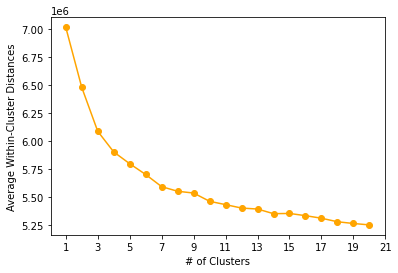

In [39]:
scores = []
for i in range(1, 21):
    scores.append(score(filled_cluster_df.sample(20000), i))
    
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('# of Clusters')

Text(0.5, 0, '# of Clusters')

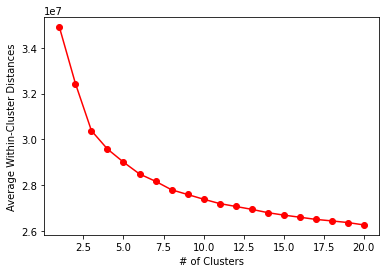

In [40]:
scores = []
for i in range(1, 21):
    scores.append(score(filled_cluster_df.sample(100000), i))
    
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='red')
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('# of Clusters')

For n_clusters = 3, silhouette score is 0.07045467413144968
For n_clusters = 4, silhouette score is 0.04535208984803244
For n_clusters = 5, silhouette score is 0.037388990230877064
For n_clusters = 6, silhouette score is 0.03567077669068118
For n_clusters = 7, silhouette score is 0.033104839716717176
For n_clusters = 8, silhouette score is 0.03234791544076181


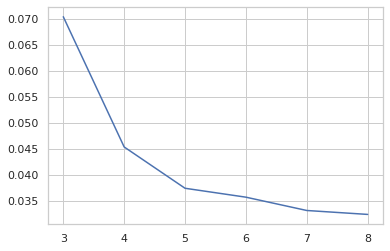

In [88]:
from sklearn.metrics import silhouette_score

sil_score = []
cluster_list = list(range(3, 9))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=101)
    x = filled_cluster_df.sample(100000)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(x, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

## Generate Clusters

In [190]:
kmeans = KMeans(n_clusters=7, random_state=101)
model = kmeans.fit(filled_cluster_df)

In [191]:
population_cluster = kmeans.predict(filled_cluster_df)
cluster_df['CLUSTER'] = population_cluster

We can define the clusters of training data and validate our clustering using the same.


In [192]:
df = pd.merge(cluster_df[['LNR', 'CLUSTER']], 
              customers[['LNR', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']],
              how='left', on='LNR')

# Create a boolean for identification of customer or not
df['is_customer'] = df.ONLINE_PURCHASE.notna()

In [193]:
df.head()

,LNR,CLUSTER,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,is_customer
0,910220,6,NaN,NaN,NaN,False
1,910225,6,NaN,NaN,NaN,False
2,910226,3,NaN,NaN,NaN,False
3,910241,0,NaN,NaN,NaN,False
4,910244,6,NaN,NaN,NaN,False


In [194]:
df.CUSTOMER_GROUP.value_counts(1)

MULTI_BUYER     0.702695
SINGLE_BUYER    0.297305
Name: CUSTOMER_GROUP, dtype: float64

In [195]:
df.ONLINE_PURCHASE.value_counts(1)

0.0    0.913541
1.0    0.086459
Name: ONLINE_PURCHASE, dtype: float64

In [196]:
df.PRODUCT_GROUP.value_counts(1)

COSMETIC_AND_FOOD    0.538045
FOOD                 0.240605
COSMETIC             0.221350
Name: PRODUCT_GROUP, dtype: float64

/home/yusuf/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yusuf/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


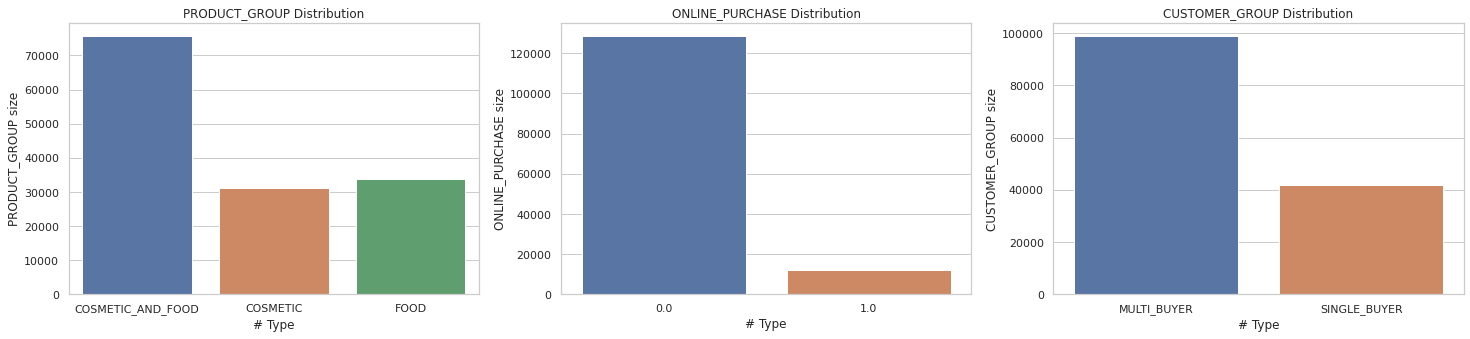

In [197]:
sns.set(style="whitegrid")
plt.figure(figsize = (25, 5))

plt.subplot(1, 3, 1)
ax1 = sns.countplot(df.PRODUCT_GROUP.values)
ax1.set_ylabel('PRODUCT_GROUP size')
ax1.set_xlabel('# Type')
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 30)
plt.title('PRODUCT_GROUP Distribution')

plt.subplot(1, 3, 2)
ax2 = sns.countplot(df.ONLINE_PURCHASE.values)
ax2.set_ylabel('ONLINE_PURCHASE size')
ax2.set_xlabel('# Type')
# ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 30)

plt.title('ONLINE_PURCHASE Distribution')

plt.subplot(1, 3, 3)
ax3 = sns.countplot(df.CUSTOMER_GROUP.values)
ax3.set_ylabel('CUSTOMER_GROUP size')
ax3.set_xlabel('# Type')
# ax3.set_xticklabels(ax3.get_xticklabels(),rotation = 30)

plt.title('CUSTOMER_GROUP Distribution')

# plt.xticks()
plt.show()

## Cluster Analysis

1. Percentage of customers in every cluster
2. Online Users percentage in every cluster
3. Distribution of Customer group type in every cluster
4. Distribution of Product type in every cluster

In [201]:
df.CLUSTER.value_counts(1)

3    0.182668
6    0.180882
0    0.179918
5    0.149422
2    0.148733
1    0.141527
4    0.016850
Name: CLUSTER, dtype: float64

/home/yusuf/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cluster Volume')

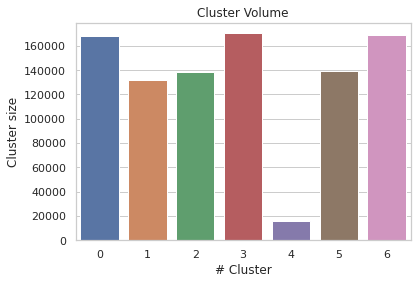

In [202]:
# Volume in every cluster
ax = sns.countplot(df.CLUSTER.values)
ax.set_ylabel('Cluster size')
ax.set_xlabel('# Cluster')

plt.title('Cluster Volume')

Text(0.5, 1.0, 'General Population vs Customer Volume')

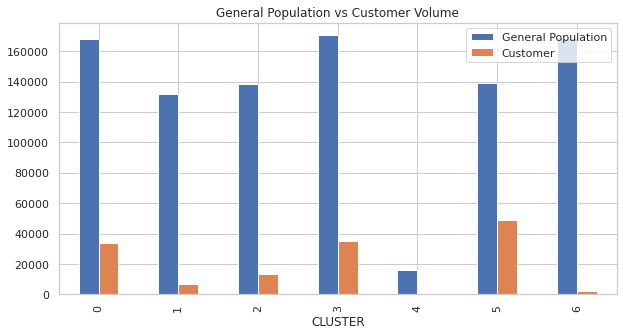

In [203]:
# Get the count of every cluster and see what is the proportion of existing customers in each one of them.

vol_dist_df = df.groupby("CLUSTER").agg({'is_customer':['count', 'sum']}).reset_index()
vol_dist_df.columns = ['CLUSTER', 'General Population', 'Customer']
vol_dist_df.groupby("CLUSTER").agg({'General Population':'sum', 'Customer':'sum'}).plot.bar(figsize=(10, 5));
ax.set_ylabel('Population Volume')
plt.title('General Population vs Customer Volume')

In [166]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

is_customer   False    True     All
CLUSTER                            
All          791988  140899  932887
5             90643   48751  139394
3            135302   35107  170409
0            134389   33454  167843
2            125120   13631  138751
1            125459    6570  132029
6            166289    2453  168742
4             14786     933   15719
------------------------------------------------------------------------------------------------------------------------


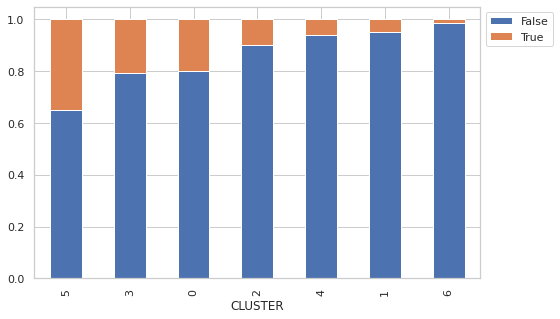

In [204]:
stacked_barplot(df, 'CLUSTER', 'is_customer')

Above stacked plot represents the volume of existing customers in every cluster. Blue represents the general population and orange represents existing customers. It is evident that cluster 0, 3, and 5 are the most representative clusters of customer demographics. 

While targeting the population for various products, Arvato should target these 3 segments. Since other clusters are very different from the company's customer base, the company can save marketing costs here.

PRODUCT_GROUP  COSMETIC  COSMETIC_AND_FOOD   FOOD     All
CLUSTER                                                  
All               31188              75810  33901  140899
5                 11933              27271   9547   48751
0                  7510              15806  10138   33454
3                  6685              20197   8225   35107
2                  2537               7473   3621   13631
1                  1755               3360   1455    6570
6                   594               1129    730    2453
4                   174                574    185     933
------------------------------------------------------------------------------------------------------------------------


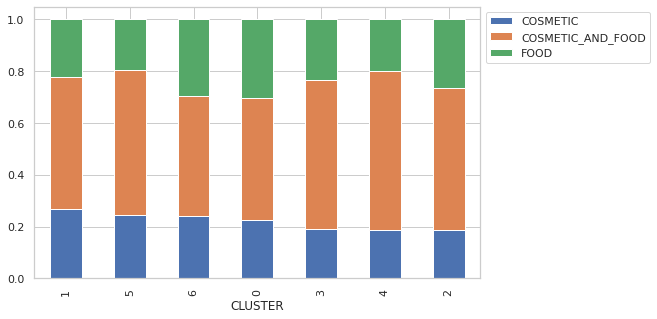

In [205]:
stacked_barplot(df, 'CLUSTER', 'PRODUCT_GROUP')

It is evident from the above plot that out of major customer clusters, Cluster 3 users have more inclination towards cosmetics and food both while cluster 0 have significant food only population as well. This can be utilized by the marketing team while sending personalized campaigns.

CUSTOMER_GROUP  MULTI_BUYER  SINGLE_BUYER     All
CLUSTER                                          
All                   99009         41890  140899
5                     35503         13248   48751
0                     21535         11919   33454
3                     25636          9471   35107
2                      9502          4129   13631
1                      4570          2000    6570
6                      1548           905    2453
4                       715           218     933
------------------------------------------------------------------------------------------------------------------------


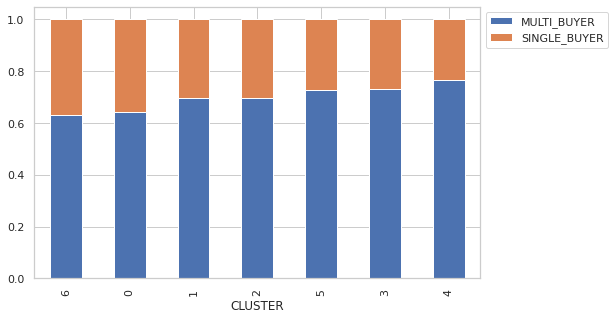

In [206]:
stacked_barplot(df, 'CLUSTER', 'CUSTOMER_GROUP')

Out of the major 3 customer like clusters, Cluster 0 represents more proportion of single buyer than cluster 3 and 5. This can be utilized by the marketing team while sending personalized campaigns.

ONLINE_PURCHASE     0.0    1.0     All
CLUSTER                               
All              128717  12182  140899
0                 28614   4840   33454
5                 45509   3242   48751
1                  5139   1431    6570
3                 33702   1405   35107
6                  1819    634    2453
2                 13048    583   13631
4                   886     47     933
------------------------------------------------------------------------------------------------------------------------


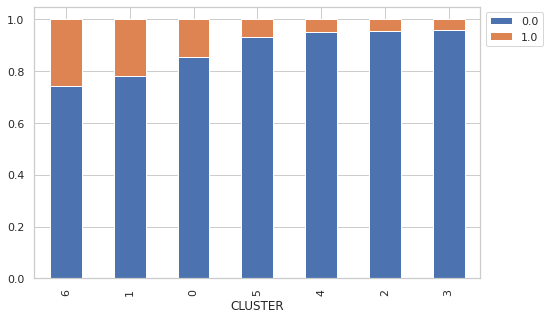

In [207]:
stacked_barplot(df, 'CLUSTER', 'ONLINE_PURCHASE')

Cluster 0 has more proportion of online purchase preference. This insight can also be utilized to market accordingly.

**This ends the Customer Segmentation Report. We will talk about the Supervised Learning Model in the next part.**

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [60]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')

/home/yusuf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [61]:
mailout_train.shape, mailout_test.shape

((42962, 367), (42833, 366))

## Data pre-processing

In [62]:
# Pre-process data using the same pipelines we created for segmentation
train_data = preprocess_data(mailout_train)
test_data = preprocess_data(mailout_test)

In [63]:
# Dropping the null majority rows/columns
train_data = train_data.drop(majority_null_columns, axis=1)
test_data = test_data.drop(majority_null_columns, axis=1)

In [64]:
train_data.shape, test_data.shape

((42962, 352), (42833, 351))

In [65]:
# Check the difference between train and test column difference
set(train_data.columns) - set(test_data.columns) 

{'RESPONSE'}

## Modeling

In [66]:
# Use the test_data columns as feature columns
features = list(test_data.columns)

X = train_data[features]
y = train_data['RESPONSE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30, random_state=42)

In [68]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(25776, 351) (8593, 351) (8593, 351)


In [131]:
from sklearn.utils.class_weight import compute_class_weight

def get_sample_weight(y):
    class_weights = compute_class_weight('balanced', classes=[0,1], y=y)
    class_weights_array = [class_weights[0] if i==0 else class_weights[1] for i in y]
    
    return class_weights_array

class_weights_array = get_sample_weight(y_train)

In [70]:
d_train = (X_train[features], y_train.values)
d_valid = (X_test[features] , y_test.values)
eval_set=[(d_train) , (d_valid)]

xgb_clf = xgb.XGBClassifier(max_depth=3)

# xgb_clf.fit(d_train[0], d_train[1], eval_metric=['auc'],
#               eval_set=eval_set, early_stopping_rounds=70, verbose=10, sample_weight= class_weights_array)

xgb_clf.fit(X_train, y_train, eval_metric=['auc'], sample_weight= class_weights_array)


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Utility functions for evaluation

In [71]:
from scipy.stats import ks_2samp

def model_pred(model, X_features):
    y_pred_prob = model.predict_proba(X_features)[:,1]
    
    return y_pred_prob
    
def get_eval_metrics(y, y_pred_prob):
    
    test_precision, test_recall, thresholds = precision_recall_curve(y, y_pred_prob)

    print('AUC ROC:', roc_auc_score(y, y_pred_prob))
    
    return roc_auc_score(y, y_pred_prob)



## Baseline model evaluation

Since, it's a classification model, and data is not balance, we will be going with evaluation metric as AUC-ROC

In [72]:
print('Train')
y_pred_prob = model_pred(xgb_clf, X_train[features])
auc_roc = get_eval_metrics(y_train.values, y_pred_prob)

print('Test')
y_pred_prob = model_pred(xgb_clf, X_test[features])
auc_roc = get_eval_metrics(y_test.values, y_pred_prob)

print('Val')
y_pred_prob = model_pred(xgb_clf, X_val[features])
auc_roc = get_eval_metrics(y_val.values, y_pred_prob)

Train
AUC ROC: 0.9878846042308974
Test
AUC ROC: 0.6311167356956587
Val
AUC ROC: 0.584696399347138


## Hyper-parameter tuning: Optuna

An open source hyperparameter optimization framework to automate hyperparameter search

In [73]:
import optuna

def objective(trial , d_train, d_valid):

    xgb_params = {"objective":"binary:logistic","use_label_encoder":True,"base_score":0.5,
              "booster":"gbtree","colsample_bylevel":0.7,"colsample_bynode":0.7,"colsample_bytree":1,
              "gamma":0,"importance_type":"gain","learning_rate":0.2,"max_delta_step":0,"max_depth":1,
              "min_child_weight":1,"n_estimators":500,"num_parallel_tree":1,"random_state":101,
              "reg_alpha":0,"reg_lambda":1,"scale_pos_weight":1,"subsample":1 ,'nthread':20}
    
    params_dict = dict(
        random_state=42,
        objective='binary:logistic',
        eval_metric=['logloss','auc'],
#         max_depth = 1,
#         max_depth=trial.suggest_int('max_depth', 1),
        reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 5.0, log=True),
        gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 100),
        subsample = trial.suggest_discrete_uniform('subsample', 0.5, 1, 0.1),
        colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree',0.5, 1.0, 0.05),
        learning_rate = trial.suggest_float("eta", 1e-8, 1.0, log=True),
        reg_lambda = trial.suggest_int('reg_lambda', 1, 6),
        nthread = 20
    )
    for key , v in  xgb_params.items():
        if key not in params_dict:
            params_dict[key] = v
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    trail_params.append(params_dict)
    
    print('params_dict',params_dict)
    
    xgboost_tuna = xgb.XGBClassifier(**params_dict)
    xgboost_tuna.fit(d_train[0], d_train[1], callbacks=[pruning_callback], 
                     eval_metric=['auc'], 
                     eval_set=[d_train, d_valid], early_stopping_rounds=30)
    
    preds = xgboost_tuna.predict_proba(d_valid[0])[:, 1]
    auc = roc_auc_score(d_valid[1], preds)
    
    return auc



In [74]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state = 101)

study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(n_startup_trials=25),
    pruner=optuna.pruners.NopPruner(),
    direction="maximize"
)


trail_params = []
study.optimize(lambda trial: objective(trial, d_train, d_valid), n_trials=100)
print(study.best_trial)

[I 2021-12-25 13:55:31,638] A new study created in memory with name: no-name-0c327ab6-cb5e-44e8-b38a-9035c0165b36
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.13374748273471096, 'gamma': 0.07766443880776949, 'min_child_weight': 51, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 3.7502629590131923e-07, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-au

[I 2021-12-25 13:55:32,488] Trial 0 finished with value: 0.5 and parameters: {'reg_alpha': 0.13374748273471096, 'gamma': 0.07766443880776949, 'min_child_weight': 51, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 3.7502629590131923e-07, 'reg_lambda': 2}. Best is trial 0 with value: 0.5.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.604018338666801e-08, 'gamma': 4.0981421473223715e-08, 'min_child_weight': 10, 'subsample': 1.0, 'colsample_bytree': 0.55, 'learning_rate': 0.0006572883609823029, 'reg_lambda': 6, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:33,139] Trial 1 finished with value: 0.5 and parameters: {'reg_alpha': 1.604018338666801e-08, 'gamma': 4.0981421473223715e-08, 'min_child_weight': 10, 'subsample': 1.0, 'colsample_bytree': 0.55, 'eta': 0.0006572883609823029, 'reg_lambda': 6}. Best is trial 0 with value: 0.5.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.739346455444743e-06, 'gamma': 5.0771770092147825e-05, 'min_child_weight': 55, 'subsample': 0.9, 'colsample_bytree': 0.5, 'learning_rate': 0.003116027008308752, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:33,792] Trial 2 finished with value: 0.5 and parameters: {'reg_alpha': 2.739346455444743e-06, 'gamma': 5.0771770092147825e-05, 'min_child_weight': 55, 'subsample': 0.9, 'colsample_bytree': 0.5, 'eta': 0.003116027008308752, 'reg_lambda': 5}. Best is trial 0 with value: 0.5.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.10249898919091381, 'gamma': 0.646350225116576, 'min_child_weight': 27, 'subsample': 0.7, 'colsample_bytree': 0.7, 'learning_rate': 1.2722181037879252e-07, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:34,482] Trial 3 finished with value: 0.5 and parameters: {'reg_alpha': 0.10249898919091381, 'gamma': 0.646350225116576, 'min_child_weight': 27, 'subsample': 0.7, 'colsample_bytree': 0.7, 'eta': 1.2722181037879252e-07, 'reg_lambda': 3}. Best is trial 0 with value: 0.5.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.822645518489363e-05, 'gamma': 3.977027412426094e-08, 'min_child_weight': 24, 'subsample': 0.7, 'colsample_bytree': 0.75, 'learning_rate': 0.022374796647479624, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:35,167] Trial 4 finished with value: 0.5 and parameters: {'reg_alpha': 3.822645518489363e-05, 'gamma': 3.977027412426094e-08, 'min_child_weight': 24, 'subsample': 0.7, 'colsample_bytree': 0.75, 'eta': 0.022374796647479624, 'reg_lambda': 4}. Best is trial 0 with value: 0.5.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.2287629308034064e-05, 'gamma': 0.004288413510797747, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 0.6, 'learning_rate': 0.0003251449900859745, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:35,839] Trial 5 finished with value: 0.5 and parameters: {'reg_alpha': 2.2287629308034064e-05, 'gamma': 0.004288413510797747, 'min_child_weight': 30, 'subsample': 0.5, 'colsample_bytree': 0.6, 'eta': 0.0003251449900859745, 'reg_lambda': 2}. Best is trial 0 with value: 0.5.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.880902077772787e-05, 'gamma': 1.513055195412095e-05, 'min_child_weight': 12, 'subsample': 0.8, 'colsample_bytree': 0.65, 'learning_rate': 0.20464266855352106, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.66595	validation_1-auc:0.65158
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.66595	validation_1-auc:0.65158
[6]	validation_0-auc:0.66595	validation_1-auc:0.65158
[7]	validation_0-auc:0.67437	validation_1-auc:0.64413
[8]	validation_0-auc:0.67437	validation_1-auc:0.64413
[9]	validation_0-auc:0.67437	validation_1-auc:0.64413
[10]	validation_0-auc:0.67437	validation_1-auc:0.64413
[11]	validation_0-auc:0.66926	validation_1-auc:0.63839
[12]	validation_0-auc:0.67261	validation_1-auc:0.63625
[13]	validation_0-auc:0.67261	validation_1-auc:0.63625
[14]	validation_0-auc:0.67261	validation_1-auc:0.63625
[15]	validation_0-auc:0.6746

[I 2021-12-25 13:55:37,613] Trial 6 finished with value: 0.6938703144209457 and parameters: {'reg_alpha': 3.880902077772787e-05, 'gamma': 1.513055195412095e-05, 'min_child_weight': 12, 'subsample': 0.8, 'colsample_bytree': 0.65, 'eta': 0.20464266855352106, 'reg_lambda': 1}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.649197857598677e-07, 'gamma': 0.0002420841544893062, 'min_child_weight': 52, 'subsample': 1.0, 'colsample_bytree': 0.7, 'learning_rate': 0.001975085954274959, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:38,263] Trial 7 finished with value: 0.5 and parameters: {'reg_alpha': 2.649197857598677e-07, 'gamma': 0.0002420841544893062, 'min_child_weight': 52, 'subsample': 1.0, 'colsample_bytree': 0.7, 'eta': 0.001975085954274959, 'reg_lambda': 5}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.02540658565790865, 'gamma': 1.3606330110407777e-08, 'min_child_weight': 60, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 9.486076950189276e-05, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:38,959] Trial 8 finished with value: 0.5 and parameters: {'reg_alpha': 0.02540658565790865, 'gamma': 1.3606330110407777e-08, 'min_child_weight': 60, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 9.486076950189276e-05, 'reg_lambda': 1}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.6609616180998948e-07, 'gamma': 0.002471696011395338, 'min_child_weight': 60, 'subsample': 0.9, 'colsample_bytree': 0.7, 'learning_rate': 0.0006862770396555227, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:39,614] Trial 9 finished with value: 0.5 and parameters: {'reg_alpha': 1.6609616180998948e-07, 'gamma': 0.002471696011395338, 'min_child_weight': 60, 'subsample': 0.9, 'colsample_bytree': 0.7, 'eta': 0.0006862770396555227, 'reg_lambda': 5}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.431204565964585e-05, 'gamma': 0.1929434517529556, 'min_child_weight': 6, 'subsample': 0.6, 'colsample_bytree': 0.6, 'learning_rate': 1.170760891427604e-06, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:40,272] Trial 10 finished with value: 0.5 and parameters: {'reg_alpha': 4.431204565964585e-05, 'gamma': 0.1929434517529556, 'min_child_weight': 6, 'subsample': 0.6, 'colsample_bytree': 0.6, 'eta': 1.170760891427604e-06, 'reg_lambda': 5}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.7438908532358226, 'gamma': 0.0007294543545555116, 'min_child_weight': 96, 'subsample': 0.8, 'colsample_bytree': 0.6, 'learning_rate': 0.03807538083689082, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:40,924] Trial 11 finished with value: 0.5 and parameters: {'reg_alpha': 0.7438908532358226, 'gamma': 0.0007294543545555116, 'min_child_weight': 96, 'subsample': 0.8, 'colsample_bytree': 0.6, 'eta': 0.03807538083689082, 'reg_lambda': 2}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.15930832200943143, 'gamma': 0.0008551927005692131, 'min_child_weight': 78, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.6251848428641129, 'reg_lambda': 6, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.66595	validation_1-auc:0.65158
[6]	validation_0-auc:0.67609	validation_1-auc:0.65696
[7]	validation_0-auc:0.67609	validation_1-auc:0.65696
[8]	validation_0-auc:0.68716	validation_1-auc:0.65234
[9]	validation_0-auc:0.68716	validation_1-auc:0.65234
[10]	validation_0-auc:0.68855	validation_1-auc:0.65723
[11]	validation_0-auc:0.69682	validation_1-auc:0.65211
[12]	validation_0-auc:0.70000	validation_1-auc:0.66438
[13]	validation_0-auc:0.70201	validation_1-auc:0.66549
[14]	validation_0-auc:0.70541	validation_1-auc:0.66512
[15]	validation_0-auc:0.7085

[I 2021-12-25 13:55:41,827] Trial 12 finished with value: 0.6654917287482965 and parameters: {'reg_alpha': 0.15930832200943143, 'gamma': 0.0008551927005692131, 'min_child_weight': 78, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.6251848428641129, 'reg_lambda': 6}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.001952682597129863, 'gamma': 2.338781795201817e-06, 'min_child_weight': 51, 'subsample': 0.8, 'colsample_bytree': 0.55, 'learning_rate': 0.001141303336324498, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:42,474] Trial 13 finished with value: 0.5 and parameters: {'reg_alpha': 0.001952682597129863, 'gamma': 2.338781795201817e-06, 'min_child_weight': 51, 'subsample': 0.8, 'colsample_bytree': 0.55, 'eta': 0.001141303336324498, 'reg_lambda': 4}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 6.250919826253187e-07, 'gamma': 1.8046036063705219e-06, 'min_child_weight': 80, 'subsample': 1.0, 'colsample_bytree': 0.75, 'learning_rate': 0.04811475646398618, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:55:43,424] Trial 14 finished with value: 0.6515853325063193 and parameters: {'reg_alpha': 6.250919826253187e-07, 'gamma': 1.8046036063705219e-06, 'min_child_weight': 80, 'subsample': 1.0, 'colsample_bytree': 0.75, 'eta': 0.04811475646398618, 'reg_lambda': 2}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 5.481951568650364e-05, 'gamma': 0.035788135870929626, 'min_child_weight': 51, 'subsample': 0.5, 'colsample_bytree': 0.8, 'learning_rate': 0.17054459777895029, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.66595	validation_1-auc:0.65158
[12]	validation_0-auc:0.66595	validation_1-auc:0.65158
[13]	validation_0-auc:0.66926	validation_1-auc:0.63839
[14]	validation_0-auc:0.66926	validation_1-auc:0.63839
[15]	validation_0-auc:0.6692

[I 2021-12-25 13:55:45,253] Trial 15 finished with value: 0.673483418591364 and parameters: {'reg_alpha': 5.481951568650364e-05, 'gamma': 0.035788135870929626, 'min_child_weight': 51, 'subsample': 0.5, 'colsample_bytree': 0.8, 'eta': 0.17054459777895029, 'reg_lambda': 4}. Best is trial 6 with value: 0.6938703144209457.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.1151544470258026, 'gamma': 1.4828654562999765e-08, 'min_child_weight': 29, 'subsample': 0.8, 'colsample_bytree': 0.7, 'learning_rate': 0.19831487189090588, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:55:47,444] Trial 16 finished with value: 0.6946995515894454 and parameters: {'reg_alpha': 2.1151544470258026, 'gamma': 1.4828654562999765e-08, 'min_child_weight': 29, 'subsample': 0.8, 'colsample_bytree': 0.7, 'eta': 0.19831487189090588, 'reg_lambda': 2}. Best is trial 16 with value: 0.6946995515894454.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 9.296476865982368e-08, 'gamma': 7.234452008059357e-05, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.5, 'learning_rate': 6.979725414270326e-05, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:48,092] Trial 17 finished with value: 0.5 and parameters: {'reg_alpha': 9.296476865982368e-08, 'gamma': 7.234452008059357e-05, 'min_child_weight': 4, 'subsample': 0.7, 'colsample_bytree': 0.5, 'eta': 6.979725414270326e-05, 'reg_lambda': 1}. Best is trial 16 with value: 0.6946995515894454.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 5.102730503825837e-06, 'gamma': 3.776227650821392e-08, 'min_child_weight': 70, 'subsample': 0.8, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.024422409782508935, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.62628	validation_1-auc:0.63263
[6]	validation_0-auc:0.62628	validation_1-auc:0.63263
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.62628	validation_1-auc:0.63263
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:55:49,005] Trial 18 finished with value: 0.6515853325063193 and parameters: {'reg_alpha': 5.102730503825837e-06, 'gamma': 3.776227650821392e-08, 'min_child_weight': 70, 'subsample': 0.8, 'colsample_bytree': 0.8500000000000001, 'eta': 0.024422409782508935, 'reg_lambda': 1}. Best is trial 16 with value: 0.6946995515894454.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.009671832273462286, 'gamma': 0.00012871479311748856, 'min_child_weight': 95, 'subsample': 0.8, 'colsample_bytree': 0.65, 'learning_rate': 3.295235089603594e-08, 'reg_lambda': 6, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:49,649] Trial 19 finished with value: 0.5 and parameters: {'reg_alpha': 0.009671832273462286, 'gamma': 0.00012871479311748856, 'min_child_weight': 95, 'subsample': 0.8, 'colsample_bytree': 0.65, 'eta': 3.295235089603594e-08, 'reg_lambda': 6}. Best is trial 16 with value: 0.6946995515894454.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.3290731617170602e-06, 'gamma': 3.446574140581074e-05, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.19044183113087362, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.58837	validation_1-auc:0.54758
[11]	validation_0-auc:0.59195	validation_1-auc:0.54514
[12]	validation_0-auc:0.59195	validation_1-auc:0.54514
[13]	validation_0-auc:0.65667	validation_1-auc:0.64264
[14]	validation_0-auc:0.64604	validation_1-auc:0.60640
[15]	validation_0-auc:0.6522

[I 2021-12-25 13:55:51,229] Trial 20 finished with value: 0.6998222586819798 and parameters: {'reg_alpha': 1.3290731617170602e-06, 'gamma': 3.446574140581074e-05, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'eta': 0.19044183113087362, 'reg_lambda': 4}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.959299100994725, 'gamma': 8.60567515907901e-08, 'min_child_weight': 83, 'subsample': 0.7, 'colsample_bytree': 0.65, 'learning_rate': 0.00012461232841538939, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:51,879] Trial 21 finished with value: 0.5 and parameters: {'reg_alpha': 4.959299100994725, 'gamma': 8.60567515907901e-08, 'min_child_weight': 83, 'subsample': 0.7, 'colsample_bytree': 0.65, 'eta': 0.00012461232841538939, 'reg_lambda': 1}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.8438211332113224e-06, 'gamma': 2.257845766214785e-07, 'min_child_weight': 61, 'subsample': 0.8, 'colsample_bytree': 0.55, 'learning_rate': 0.0003073710451321463, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:52,502] Trial 22 finished with value: 0.5 and parameters: {'reg_alpha': 4.8438211332113224e-06, 'gamma': 2.257845766214785e-07, 'min_child_weight': 61, 'subsample': 0.8, 'colsample_bytree': 0.55, 'eta': 0.0003073710451321463, 'reg_lambda': 4}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.2191239069272945e-05, 'gamma': 0.005608888796597068, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 1.109316077488475e-07, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:53,175] Trial 23 finished with value: 0.5 and parameters: {'reg_alpha': 2.2191239069272945e-05, 'gamma': 0.005608888796597068, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 1.109316077488475e-07, 'reg_lambda': 3}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 5.511451841772072e-08, 'gamma': 1.6353620833174326e-06, 'min_child_weight': 9, 'subsample': 1.0, 'colsample_bytree': 0.6, 'learning_rate': 6.077579606656082e-07, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:53,810] Trial 24 finished with value: 0.5 and parameters: {'reg_alpha': 5.511451841772072e-08, 'gamma': 1.6353620833174326e-06, 'min_child_weight': 9, 'subsample': 1.0, 'colsample_bytree': 0.6, 'eta': 6.077579606656082e-07, 'reg_lambda': 4}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.0002851106905887463, 'gamma': 1.1148956897900034e-05, 'min_child_weight': 38, 'subsample': 0.9, 'colsample_bytree': 0.8, 'learning_rate': 0.7206945728355457, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.66261	validation_1-auc:0.62041
[6]	validation_0-auc:0.67790	validation_1-auc:0.62257
[7]	validation_0-auc:0.67245	validation_1-auc:0.62135
[8]	validation_0-auc:0.67974	validation_1-auc:0.62233
[9]	validation_0-auc:0.67356	validation_1-auc:0.60434
[10]	validation_0-auc:0.69499	validation_1-auc:0.65248
[11]	validation_0-auc:0.70284	validation_1-auc:0.64247


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[12]	validation_0-auc:0.71508	validation_1-auc:0.66341
[13]	validation_0-auc:0.71854	validation_1-auc:0.66109
[14]	validation_0-auc:0.71860	validation_1-auc:0.67028
[15]	validation_0-auc:0.72295	validation_1-auc:0.67583
[16]	validation_0-auc:0.72620	validation_1-auc:0.67294
[17]	validation_0-auc:0.72803	validation_1-auc:0.67032
[18]	validation_0-auc:0.72994	validation_1-auc:0.66600
[19]	validation_0-auc:0.73145	validation_1-auc:0.67518
[20]	validation_0-auc:0.73484	validation_1-auc:0.67396
[21]	validation_0-auc:0.73659	validation_1-auc:0.67208
[22]	validation_0-auc:0.73651	validation_1-auc:0.66895
[23]	validation_0-auc:0.73819	validation_1-auc:0.66558
[24]	validation_0-auc:0.73847	validation_1-auc:0.66247
[25]	validation_0-auc:0.74185	validation_1-auc:0.66587
[26]	validation_0-auc:0.74170	validation_1-auc:0.66344
[27]	validation_0-auc:0.74509	validation_1-auc:0.65986
[28]	validation_0-auc:0.74756	validation_1-auc:0.64900
[29]	validation_0-auc:0.74883	validation_1-auc:0.65899
[30]	valid

[I 2021-12-25 13:55:55,014] Trial 25 finished with value: 0.6758255133822872 and parameters: {'reg_alpha': 0.0002851106905887463, 'gamma': 1.1148956897900034e-05, 'min_child_weight': 38, 'subsample': 0.9, 'colsample_bytree': 0.8, 'eta': 0.7206945728355457, 'reg_lambda': 3}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.0003111632139269688, 'gamma': 2.233494238406644e-05, 'min_child_weight': 18, 'subsample': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.1806577203792227, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.58837	validation_1-auc:0.54758
[10]	validation_0-auc:0.66595	validation_1-auc:0.65158
[11]	validation_0-auc:0.65173	validation_1-auc:0.61299
[12]	validation_0-auc:0.66595	validation_1-auc:0.65158
[13]	validation_0-auc:0.67425	validation_1-auc:0.64010
[14]	validation_0-auc:0.67437	validation_1-auc:0.64413
[15]	validation_0-auc:0.6743

[I 2021-12-25 13:55:56,643] Trial 26 finished with value: 0.6925769934483593 and parameters: {'reg_alpha': 0.0003111632139269688, 'gamma': 2.233494238406644e-05, 'min_child_weight': 18, 'subsample': 0.8, 'colsample_bytree': 0.8, 'eta': 0.1806577203792227, 'reg_lambda': 3}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.0011933334112045242, 'gamma': 3.530754548195073e-07, 'min_child_weight': 38, 'subsample': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.004824522883841892, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:57,387] Trial 27 finished with value: 0.5 and parameters: {'reg_alpha': 0.0011933334112045242, 'gamma': 3.530754548195073e-07, 'min_child_weight': 38, 'subsample': 0.9, 'colsample_bytree': 0.9, 'eta': 0.004824522883841892, 'reg_lambda': 2}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 8.404787185309741e-07, 'gamma': 5.7909746403908155e-06, 'min_child_weight': 17, 'subsample': 0.9, 'colsample_bytree': 0.65, 'learning_rate': 1.0730029487383595e-05, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:55:58,273] Trial 28 finished with value: 0.6326312606850433 and parameters: {'reg_alpha': 8.404787185309741e-07, 'gamma': 5.7909746403908155e-06, 'min_child_weight': 17, 'subsample': 0.9, 'colsample_bytree': 0.65, 'eta': 1.0730029487383595e-05, 'reg_lambda': 1}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.275294421192222e-06, 'gamma': 3.8536273788374725e-07, 'min_child_weight': 39, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.9443507487289039, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.58837	validation_1-auc:0.54758
[2]	validation_0-auc:0.58837	validation_1-auc:0.54758
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.69059	validation_1-auc:0.68711
[6]	validation_0-auc:0.69214	validation_1-auc:0.69242
[7]	validation_0-auc:0.69688	validation_1-auc:0.69832
[8]	validation_0-auc:0.70148	validation_1-auc:0.68581
[9]	validation_0-auc:0.70803	validation_1-auc:0.68929
[10]	validation_0-auc:0.70544	validation_1-auc:0.68489
[11]	validation_0-auc:0.71334	validation_1-auc:0.67529
[12]	validation_0-auc:0.71564	validation_1-auc:0.67216
[13]	validation_0-auc:0.71481	validation_1-auc:0.67868
[14]	validation_0-auc:0.71885	validation_1-auc:0.67267
[15]	validation_0-auc:0.7226

[I 2021-12-25 13:55:59,048] Trial 29 finished with value: 0.6983221842062556 and parameters: {'reg_alpha': 1.275294421192222e-06, 'gamma': 3.8536273788374725e-07, 'min_child_weight': 39, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.9443507487289039, 'reg_lambda': 2}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.21780181374871e-08, 'gamma': 4.683324118723249e-07, 'min_child_weight': 44, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 0.5124442254543955, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.64354	validation_1-auc:0.57952
[5]	validation_0-auc:0.65362	validation_1-auc:0.59157
[6]	validation_0-auc:0.65362	validation_1-auc:0.59157
[7]	validation_0-auc:0.67425	validation_1-auc:0.64010
[8]	validation_0-auc:0.66015	validation_1-auc:0.60553
[9]	validation_0-auc:0.67425	validation_1-auc:0.64010
[10]	validation_0-auc:0.68561	validation_1-auc:0.64290
[11]	validation_0-auc:0.68429	validation_1-auc:0.63935
[12]	validation_0-auc:0.68590	validation_1-auc:0.65128
[13]	validation_0-auc:0.69452	validation_1-auc:0.66675
[14]	validation_0-auc:0.69375	validation_1-auc:0.66688
[15]	validation_0-auc:0.6955

[I 2021-12-25 13:56:00,477] Trial 30 finished with value: 0.6967392971714788 and parameters: {'reg_alpha': 1.21780181374871e-08, 'gamma': 4.683324118723249e-07, 'min_child_weight': 44, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 0.5124442254543955, 'reg_lambda': 2}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.4591062509319356e-08, 'gamma': 4.3234493563909676e-07, 'min_child_weight': 41, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 0.6110116411850445, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.65173	validation_1-auc:0.61299
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.64354	validation_1-auc:0.57952
[5]	validation_0-auc:0.65362	validation_1-auc:0.59157
[6]	validation_0-auc:0.63977	validation_1-auc:0.57133
[7]	validation_0-auc:0.67057	validation_1-auc:0.63113
[8]	validation_0-auc:0.68679	validation_1-auc:0.63033
[9]	validation_0-auc:0.68514	validation_1-auc:0.65110
[10]	validation_0-auc:0.68722	validation_1-auc:0.63594
[11]	validation_0-auc:0.68908	validation_1-auc:0.63279
[12]	validation_0-auc:0.68738	validation_1-auc:0.63880
[13]	validation_0-auc:0.69505	validation_1-auc:0.64275
[14]	validation_0-auc:0.69943	validation_1-auc:0.65904
[15]	validation_0-auc:0.7050

[I 2021-12-25 13:56:01,630] Trial 31 finished with value: 0.6711574416810615 and parameters: {'reg_alpha': 1.4591062509319356e-08, 'gamma': 4.3234493563909676e-07, 'min_child_weight': 41, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 0.6110116411850445, 'reg_lambda': 2}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.7553449624967206e-08, 'gamma': 1.5830787579446864e-07, 'min_child_weight': 43, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.009286759372061667, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:02,338] Trial 32 finished with value: 0.5 and parameters: {'reg_alpha': 2.7553449624967206e-08, 'gamma': 1.5830787579446864e-07, 'min_child_weight': 43, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.009286759372061667, 'reg_lambda': 3}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.3170404513269718e-06, 'gamma': 1.3463644900366689e-08, 'min_child_weight': 32, 'subsample': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.11770802831149453, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.62628	validation_1-auc:0.63263
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.66595	validation_1-auc:0.65158
[13]	validation_0-auc:0.66595	validation_1-auc:0.65158
[14]	validation_0-auc:0.66595	validation_1-auc:0.65158
[15]	validation_0-auc:0.6659

[I 2021-12-25 13:56:04,313] Trial 33 finished with value: 0.6751157708459776 and parameters: {'reg_alpha': 1.3170404513269718e-06, 'gamma': 1.3463644900366689e-08, 'min_child_weight': 32, 'subsample': 0.5, 'colsample_bytree': 1.0, 'eta': 0.11770802831149453, 'reg_lambda': 2}. Best is trial 20 with value: 0.6998222586819798.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.2557762219525027e-08, 'gamma': 8.596296772792399e-07, 'min_child_weight': 21, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.7641826226683597, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.58837	validation_1-auc:0.54758
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.66595	validation_1-auc:0.65158
[6]	validation_0-auc:0.67460	validation_1-auc:0.67529
[7]	validation_0-auc:0.69726	validation_1-auc:0.70252
[8]	validation_0-auc:0.69840	validation_1-auc:0.68476
[9]	validation_0-auc:0.69903	validation_1-auc:0.69548
[10]	validation_0-auc:0.70909	validation_1-auc:0.69564
[11]	validation_0-auc:0.71308	validation_1-auc:0.68180
[12]	validation_0-auc:0.71896	validation_1-auc:0.67812
[13]	validation_0-auc:0.71898	validation_1-auc:0.68243
[14]	validation_0-auc:0.72371	validation_1-auc:0.67529
[15]	validation_0-auc:0.7261

[I 2021-12-25 13:56:05,090] Trial 34 finished with value: 0.702515056323656 and parameters: {'reg_alpha': 1.2557762219525027e-08, 'gamma': 8.596296772792399e-07, 'min_child_weight': 21, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.7641826226683597, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.0204621845161907e-08, 'gamma': 5.427234555538332e-07, 'min_child_weight': 22, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.8759542100710457, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.58837	validation_1-auc:0.54758
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.69059	validation_1-auc:0.68711
[6]	validation_0-auc:0.66675	validation_1-auc:0.67961
[7]	validation_0-auc:0.68821	validation_1-auc:0.67503
[8]	validation_0-auc:0.69050	validation_1-auc:0.64051
[9]	validation_0-auc:0.70448	validation_1-auc:0.68364
[10]	validation_0-auc:0.70731	validation_1-auc:0.68276
[11]	validation_0-auc:0.70683	validation_1-auc:0.66914
[12]	validation_0-auc:0.71455	validation_1-auc:0.66881
[13]	validation_0-auc:0.71476	validation_1-auc:0.67087
[14]	validation_0-auc:0.72176	validation_1-auc:0.66870
[15]	validation_0-auc:0.7192

[I 2021-12-25 13:56:06,033] Trial 35 finished with value: 0.6942048993910777 and parameters: {'reg_alpha': 1.0204621845161907e-08, 'gamma': 5.427234555538332e-07, 'min_child_weight': 22, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.8759542100710457, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.4260270149541275e-08, 'gamma': 9.871378607307492e-07, 'min_child_weight': 17, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.4195618980819978, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.53809	validation_1-auc:0.48135
[5]	validation_0-auc:0.64092	validation_1-auc:0.61972
[6]	validation_0-auc:0.62482	validation_1-auc:0.58994
[7]	validation_0-auc:0.64354	validation_1-auc:0.57952
[8]	validation_0-auc:0.64847	validation_1-auc:0.56604
[9]	validation_0-auc:0.64205	validation_1-auc:0.56622
[10]	validation_0-auc:0.67587	validation_1-auc:0.64496
[11]	validation_0-auc:0.68108	validation_1-auc:0.64051
[12]	validation_0-auc:0.68660	validation_1-auc:0.63828
[13]	validation_0-auc:0.68641	validation_1-auc:0.65155
[14]	validation_0-auc:0.69865	validation_1-auc:0.64312
[15]	validation_0-auc:0.7023

[I 2021-12-25 13:56:07,132] Trial 36 finished with value: 0.6846836782559786 and parameters: {'reg_alpha': 3.4260270149541275e-08, 'gamma': 9.871378607307492e-07, 'min_child_weight': 17, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.4195618980819978, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.189835617370155e-07, 'gamma': 6.4512959788313925e-06, 'min_child_weight': 45, 'subsample': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.05382911909344233, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:08,468] Trial 37 finished with value: 0.6627333480061626 and parameters: {'reg_alpha': 3.189835617370155e-07, 'gamma': 6.4512959788313925e-06, 'min_child_weight': 45, 'subsample': 0.5, 'colsample_bytree': 1.0, 'eta': 0.05382911909344233, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 8.17732575645426e-06, 'gamma': 7.867668929444077e-08, 'min_child_weight': 35, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.010615195924282768, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:09,129] Trial 38 finished with value: 0.5 and parameters: {'reg_alpha': 8.17732575645426e-06, 'gamma': 7.867668929444077e-08, 'min_child_weight': 35, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.010615195924282768, 'reg_lambda': 4}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 9.756855872265246e-08, 'gamma': 3.6196342982498844e-05, 'min_child_weight': 25, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.8822384806172764, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.65494	validation_1-auc:0.64653
[6]	validation_0-auc:0.66148	validation_1-auc:0.66309
[7]	validation_0-auc:0.66623	validation_1-auc:0.63799
[8]	validation_0-auc:0.67324	validation_1-auc:0.63886
[9]	validation_0-auc:0.68599	validation_1-auc:0.63912
[10]	validation_0-auc:0.69401	validation_1-auc:0.62160
[11]	validation_0-auc:0.69920	validation_1-auc:0.63438
[12]	validation_0-auc:0.70030	validation_1-auc:0.62965
[13]	validation_0-auc:0.70700	validation_1-auc:0.64594
[14]	validation_0-auc:0.71058	validation_1-auc:0.63961
[15]	validation_0-auc:0.7107

[I 2021-12-25 13:56:10,058] Trial 39 finished with value: 0.6773000215646127 and parameters: {'reg_alpha': 9.756855872265246e-08, 'gamma': 3.6196342982498844e-05, 'min_child_weight': 25, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'eta': 0.8822384806172764, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.511660099319431e-06, 'gamma': 3.4282510759594346e-06, 'min_child_weight': 13, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.08318916795432596, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6265

[I 2021-12-25 13:56:12,296] Trial 40 finished with value: 0.6870452256614443 and parameters: {'reg_alpha': 2.511660099319431e-06, 'gamma': 3.4282510759594346e-06, 'min_child_weight': 13, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.08318916795432596, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.753063703714611e-08, 'gamma': 2.8498111157463455e-08, 'min_child_weight': 28, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.2987843492575712, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.53809	validation_1-auc:0.48135
[5]	validation_0-auc:0.59978	validation_1-auc:0.52506
[6]	validation_0-auc:0.60987	validation_1-auc:0.53711
[7]	validation_0-auc:0.66463	validation_1-auc:0.61100
[8]	validation_0-auc:0.66015	validation_1-auc:0.60553
[9]	validation_0-auc:0.67437	validation_1-auc:0.64413
[10]	validation_0-auc:0.67437	validation_1-auc:0.64413
[11]	validation_0-auc:0.66914	validation_1-auc:0.63436
[12]	validation_0-auc:0.66926	validation_1-auc:0.63839
[13]	validation_0-auc:0.66926	validation_1-auc:0.63839
[14]	validation_0-auc:0.66926	validation_1-auc:0.63839
[15]	validation_0-auc:0.6866

[I 2021-12-25 13:56:13,399] Trial 41 finished with value: 0.6944183223620588 and parameters: {'reg_alpha': 1.753063703714611e-08, 'gamma': 2.8498111157463455e-08, 'min_child_weight': 28, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.2987843492575712, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.913453352443796e-07, 'gamma': 7.715972050756355e-07, 'min_child_weight': 46, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.96828884479487, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.58837	validation_1-auc:0.54758
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.67613	validation_1-auc:0.64308
[6]	validation_0-auc:0.67196	validation_1-auc:0.67682
[7]	validation_0-auc:0.67698	validation_1-auc:0.66343
[8]	validation_0-auc:0.68969	validation_1-auc:0.66141
[9]	validation_0-auc:0.69000	validation_1-auc:0.67491
[10]	validation_0-auc:0.69839	validation_1-auc:0.67700
[11]	validation_0-auc:0.70136	validation_1-auc:0.66353
[12]	validation_0-auc:0.70496	validation_1-auc:0.67002
[13]	validation_0-auc:0.70260	validation_1-auc:0.67004
[14]	validation_0-auc:0.70873	validation_1-auc:0.65251
[15]	validation_0-auc:0.7089

[I 2021-12-25 13:56:14,229] Trial 42 finished with value: 0.6770015628786314 and parameters: {'reg_alpha': 3.913453352443796e-07, 'gamma': 7.715972050756355e-07, 'min_child_weight': 46, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.96828884479487, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.1419521525217308e-08, 'gamma': 1.1902590489645656e-07, 'min_child_weight': 32, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.2847715038718642, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.62628	validation_1-auc:0.63263
[6]	validation_0-auc:0.62123	validation_1-auc:0.62404
[7]	validation_0-auc:0.62357	validation_1-auc:0.58583
[8]	validation_0-auc:0.62348	validation_1-auc:0.58918
[9]	validation_0-auc:0.65429	validation_1-auc:0.59909
[10]	validation_0-auc:0.65411	validation_1-auc:0.59029
[11]	validation_0-auc:0.65555	validation_1-auc:0.58992
[12]	validation_0-auc:0.65349	validation_1-auc:0.61335
[13]	validation_0-auc:0.68671	validation_1-auc:0.66335
[14]	validation_0-auc:0.68229	validation_1-auc:0.64456
[15]	validation_0-auc:0.6833

[I 2021-12-25 13:56:15,740] Trial 43 finished with value: 0.6837310559323805 and parameters: {'reg_alpha': 1.1419521525217308e-08, 'gamma': 1.1902590489645656e-07, 'min_child_weight': 32, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.2847715038718642, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.0001178375076605338, 'gamma': 1.7992232650518495e-08, 'min_child_weight': 22, 'subsample': 0.5, 'colsample_bytree': 0.75, 'learning_rate': 0.017144585454882434, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:16,396] Trial 44 finished with value: 0.5 and parameters: {'reg_alpha': 0.0001178375076605338, 'gamma': 1.7992232650518495e-08, 'min_child_weight': 22, 'subsample': 0.5, 'colsample_bytree': 0.75, 'eta': 0.017144585454882434, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.751879705292657, 'gamma': 1.0206031465379511e-08, 'min_child_weight': 27, 'subsample': 0.6, 'colsample_bytree': 0.7, 'learning_rate': 0.08926307372688774, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:18,300] Trial 45 finished with value: 0.6860420265400358 and parameters: {'reg_alpha': 4.751879705292657, 'gamma': 1.0206031465379511e-08, 'min_child_weight': 27, 'subsample': 0.6, 'colsample_bytree': 0.7, 'eta': 0.08926307372688774, 'reg_lambda': 5}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.2821204438620942e-07, 'gamma': 5.4718596563255415e-08, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.9, 'learning_rate': 0.3067153860152975, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.66595	validation_1-auc:0.65158
[4]	validation_0-auc:0.66914	validation_1-auc:0.63436
[5]	validation_0-auc:0.66463	validation_1-auc:0.61100
[6]	validation_0-auc:0.64354	validation_1-auc:0.57952
[7]	validation_0-auc:0.65810	validation_1-auc:0.59705
[8]	validation_0-auc:0.65556	validation_1-auc:0.57180
[9]	validation_0-auc:0.65429	validation_1-auc:0.56920
[10]	validation_0-auc:0.68043	validation_1-auc:0.63838
[11]	validation_0-auc:0.67080	validation_1-auc:0.61425
[12]	validation_0-auc:0.68039	validation_1-auc:0.62025
[13]	validation_0-auc:0.68975	validation_1-auc:0.64355
[14]	validation_0-auc:0.68829	validation_1-auc:0.65000
[15]	validation_0-auc:0.6938

[I 2021-12-25 13:56:19,763] Trial 46 finished with value: 0.6870663456429478 and parameters: {'reg_alpha': 1.2821204438620942e-07, 'gamma': 5.4718596563255415e-08, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.9, 'eta': 0.3067153860152975, 'reg_lambda': 1}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.1776352350546306e-05, 'gamma': 4.0116364352755025e-06, 'min_child_weight': 13, 'subsample': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.10200150576568776, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:56:21,409] Trial 47 finished with value: 0.6929871657207138 and parameters: {'reg_alpha': 1.1776352350546306e-05, 'gamma': 4.0116364352755025e-06, 'min_child_weight': 13, 'subsample': 0.8, 'colsample_bytree': 1.0, 'eta': 0.10200150576568776, 'reg_lambda': 4}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.8924996450015788e-06, 'gamma': 1.1351477515191473e-05, 'min_child_weight': 56, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.025359857524780052, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:22,080] Trial 48 finished with value: 0.5 and parameters: {'reg_alpha': 1.8924996450015788e-06, 'gamma': 1.1351477515191473e-05, 'min_child_weight': 56, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.025359857524780052, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.5777123719392062, 'gamma': 0.0003772217222672155, 'min_child_weight': 35, 'subsample': 0.6, 'colsample_bytree': 0.8, 'learning_rate': 0.42192913183429975, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.65173	validation_1-auc:0.61299
[5]	validation_0-auc:0.65173	validation_1-auc:0.61299
[6]	validation_0-auc:0.64983	validation_1-auc:0.59389
[7]	validation_0-auc:0.65289	validation_1-auc:0.57451
[8]	validation_0-auc:0.66083	validation_1-auc:0.57086
[9]	validation_0-auc:0.66009	validation_1-auc:0.57228
[10]	validation_0-auc:0.68322	validation_1-auc:0.63719
[11]	validation_0-auc:0.67732	validation_1-auc:0.61859
[12]	validation_0-auc:0.68478	validation_1-auc:0.64267
[13]	validation_0-auc:0.69040	validation_1-auc:0.64935
[14]	validation_0-auc:0.68730	validation_1-auc:0.66153
[15]	validation_0-auc:0.6946

[I 2021-12-25 13:56:23,545] Trial 49 finished with value: 0.6760000311241834 and parameters: {'reg_alpha': 0.5777123719392062, 'gamma': 0.0003772217222672155, 'min_child_weight': 35, 'subsample': 0.6, 'colsample_bytree': 0.8, 'eta': 0.42192913183429975, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.025104125135471084, 'gamma': 1.794597091210355e-07, 'min_child_weight': 21, 'subsample': 0.8, 'colsample_bytree': 0.7, 'learning_rate': 0.006267643455187816, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:24,184] Trial 50 finished with value: 0.5 and parameters: {'reg_alpha': 0.025104125135471084, 'gamma': 1.794597091210355e-07, 'min_child_weight': 21, 'subsample': 0.8, 'colsample_bytree': 0.7, 'eta': 0.006267643455187816, 'reg_lambda': 4}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.23340614784682e-08, 'gamma': 2.3765760936534203e-08, 'min_child_weight': 28, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.21923210291791478, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.58837	validation_1-auc:0.54758
[6]	validation_0-auc:0.58837	validation_1-auc:0.54758
[7]	validation_0-auc:0.65173	validation_1-auc:0.61299
[8]	validation_0-auc:0.65173	validation_1-auc:0.61299
[9]	validation_0-auc:0.66595	validation_1-auc:0.65158
[10]	validation_0-auc:0.66595	validation_1-auc:0.65158
[11]	validation_0-auc:0.67437	validation_1-auc:0.64413
[12]	validation_0-auc:0.67437	validation_1-auc:0.64413
[13]	validation_0-auc:0.67437	validation_1-auc:0.64413
[14]	validation_0-auc:0.67437	validation_1-auc:0.64413
[15]	validation_0-auc:0.6743

[I 2021-12-25 13:56:25,470] Trial 51 finished with value: 0.6850910715833984 and parameters: {'reg_alpha': 3.23340614784682e-08, 'gamma': 2.3765760936534203e-08, 'min_child_weight': 28, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.21923210291791478, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.109736728603738e-08, 'gamma': 3.334424199622316e-08, 'min_child_weight': 30, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.9491486291192839, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.65173	validation_1-auc:0.61299
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.64354	validation_1-auc:0.57952
[5]	validation_0-auc:0.65362	validation_1-auc:0.59157
[6]	validation_0-auc:0.64126	validation_1-auc:0.56785
[7]	validation_0-auc:0.66714	validation_1-auc:0.60501
[8]	validation_0-auc:0.68052	validation_1-auc:0.61488
[9]	validation_0-auc:0.68741	validation_1-auc:0.62618
[10]	validation_0-auc:0.70278	validation_1-auc:0.65239
[11]	validation_0-auc:0.70255	validation_1-auc:0.64861
[12]	validation_0-auc:0.70520	validation_1-auc:0.65633
[13]	validation_0-auc:0.71042	validation_1-auc:0.65869
[14]	validation_0-auc:0.71304	validation_1-auc:0.64915
[15]	validation_0-auc:0.7174

[I 2021-12-25 13:56:26,358] Trial 52 finished with value: 0.6586944294381417 and parameters: {'reg_alpha': 1.109736728603738e-08, 'gamma': 3.334424199622316e-08, 'min_child_weight': 30, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.9491486291192839, 'reg_lambda': 1}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 5.1772269182520756e-08, 'gamma': 9.85679359335039e-07, 'min_child_weight': 47, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.05620245477720451, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:56:27,371] Trial 53 finished with value: 0.6515853325063193 and parameters: {'reg_alpha': 5.1772269182520756e-08, 'gamma': 9.85679359335039e-07, 'min_child_weight': 47, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.05620245477720451, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.7602117855314687e-07, 'gamma': 3.2423443594893237e-07, 'min_child_weight': 39, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.3449005161187077, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.59978	validation_1-auc:0.52506
[5]	validation_0-auc:0.60987	validation_1-auc:0.53711
[6]	validation_0-auc:0.60987	validation_1-auc:0.53711
[7]	validation_0-auc:0.66463	validation_1-auc:0.61100
[8]	validation_0-auc:0.66015	validation_1-auc:0.60553
[9]	validation_0-auc:0.67425	validation_1-auc:0.64010
[10]	validation_0-auc:0.67437	validation_1-auc:0.64413
[11]	validation_0-auc:0.68196	validation_1-auc:0.65015
[12]	validation_0-auc:0.68196	validation_1-auc:0.65015
[13]	validation_0-auc:0.69450	validation_1-auc:0.67068
[14]	validation_0-auc:0.69392	validation_1-auc:0.67118
[15]	validation_0-auc:0.6997

[I 2021-12-25 13:56:28,313] Trial 54 finished with value: 0.6776090402413457 and parameters: {'reg_alpha': 1.7602117855314687e-07, 'gamma': 3.2423443594893237e-07, 'min_child_weight': 39, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.3449005161187077, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.2780647329388373e-08, 'gamma': 6.282744285008039e-08, 'min_child_weight': 35, 'subsample': 0.8, 'colsample_bytree': 0.95, 'learning_rate': 0.1551187325677812, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.62628	validation_1-auc:0.63263
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.66595	validation_1-auc:0.65158
[15]	validation_0-auc:0.6645

[I 2021-12-25 13:56:29,887] Trial 55 finished with value: 0.6883374350560569 and parameters: {'reg_alpha': 2.2780647329388373e-08, 'gamma': 6.282744285008039e-08, 'min_child_weight': 35, 'subsample': 0.8, 'colsample_bytree': 0.95, 'eta': 0.1551187325677812, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 7.073724954328031e-07, 'gamma': 1.6994408337254983e-06, 'min_child_weight': 25, 'subsample': 0.6, 'colsample_bytree': 0.7, 'learning_rate': 0.002092369764268118, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:30,517] Trial 56 finished with value: 0.5 and parameters: {'reg_alpha': 7.073724954328031e-07, 'gamma': 1.6994408337254983e-06, 'min_child_weight': 25, 'subsample': 0.6, 'colsample_bytree': 0.7, 'eta': 0.002092369764268118, 'reg_lambda': 1}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 7.136651860880545e-08, 'gamma': 1.1001490543918319e-08, 'min_child_weight': 18, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.02955632494822214, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.50000	validation_1-auc:0.50000
[16]	validation_0-auc:0.50000	validation_1-auc:0.50000
[17]	validation_0-auc:0.50000	validation_1-auc:0.50000
[18]	validation_0-auc:0.50000	validation_1-auc:0.50000
[19]	validation_0-auc:0.50000	validation_1-auc:0.50000
[20]	validation_0-auc:0.50000	validation_1-auc:0.50000
[21]	validation_0-auc:0.50000	validation_1-auc:0.50000
[22]	validation_0-auc:0.50000	validation_1-auc:0.50000
[23]	validation_0-auc:0.50000	validation_1-auc:0.50000
[24]	validation_0-auc:0.50000	validation_1-auc:0.50000
[25]	validation_0-auc:0.50000	validation_1-auc:0.50000
[26]	validation_0-auc:0.50000	validation_1-auc:0.50000
[27]	validation_0-auc:0.50000	validation_1-auc:0.50000
[28]	validation_0-auc:0.50000	validation_1-auc:0.50000
[29]	validation_0-auc:0.50000	validation_1-auc:0.50000
Stopping. Best iteration:
[0]	validation_0-auc:0.50000	validation

[I 2021-12-25 13:56:31,287] Trial 57 finished with value: 0.5 and parameters: {'reg_alpha': 7.136651860880545e-08, 'gamma': 1.1001490543918319e-08, 'min_child_weight': 18, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'eta': 0.02955632494822214, 'reg_lambda': 5}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.0032425826247484005, 'gamma': 0.00013798196507680777, 'min_child_weight': 54, 'subsample': 0.5, 'colsample_bytree': 0.9, 'learning_rate': 0.9622032029088575, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.63146	validation_1-auc:0.59909
[5]	validation_0-auc:0.67584	validation_1-auc:0.66814
[6]	validation_0-auc:0.68410	validation_1-auc:0.65607
[7]	validation_0-auc:0.68796	validation_1-auc:0.63452
[8]	validation_0-auc:0.69066	validation_1-auc:0.64459
[9]	validation_0-auc:0.68645	validation_1-auc:0.63618
[10]	validation_0-auc:0.68826	validation_1-auc:0.64459
[11]	validation_0-auc:0.68671	validation_1-auc:0.62378
[12]	validation_0-auc:0.68245	validation_1-auc:0.61412
[13]	validation_0-auc:0.70037	validation_1-auc:0.62977
[14]	validation_0-auc:0.69505	validation_1-auc:0.62844
[15]	validation_0-auc:0.7005

[I 2021-12-25 13:56:32,009] Trial 58 finished with value: 0.6681422864269659 and parameters: {'reg_alpha': 0.0032425826247484005, 'gamma': 0.00013798196507680777, 'min_child_weight': 54, 'subsample': 0.5, 'colsample_bytree': 0.9, 'eta': 0.9622032029088575, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.2383651984291157e-07, 'gamma': 3.131585294788794e-08, 'min_child_weight': 11, 'subsample': 0.6, 'colsample_bytree': 0.75, 'learning_rate': 0.4661904448295617, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.65173	validation_1-auc:0.61299
[6]	validation_0-auc:0.66595	validation_1-auc:0.65158
[7]	validation_0-auc:0.65173	validation_1-auc:0.61299
[8]	validation_0-auc:0.66595	validation_1-auc:0.65158
[9]	validation_0-auc:0.66812	validation_1-auc:0.64892
[10]	validation_0-auc:0.66886	validation_1-auc:0.65071
[11]	validation_0-auc:0.68223	validation_1-auc:0.65326
[12]	validation_0-auc:0.69348	validation_1-auc:0.66006
[13]	validation_0-auc:0.69823	validation_1-auc:0.64206
[14]	validation_0-auc:0.69768	validation_1-auc:0.65787
[15]	validation_0-auc:0.6993

[I 2021-12-25 13:56:33,013] Trial 59 finished with value: 0.6777302022404965 and parameters: {'reg_alpha': 2.2383651984291157e-07, 'gamma': 3.131585294788794e-08, 'min_child_weight': 11, 'subsample': 0.6, 'colsample_bytree': 0.75, 'eta': 0.4661904448295617, 'reg_lambda': 2}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.0420347446550667e-05, 'gamma': 1.9961477548304114e-07, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.95, 'learning_rate': 1.4265021312020228e-05, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:33,637] Trial 60 finished with value: 0.5 and parameters: {'reg_alpha': 2.0420347446550667e-05, 'gamma': 1.9961477548304114e-07, 'min_child_weight': 3, 'subsample': 0.8, 'colsample_bytree': 0.95, 'eta': 1.4265021312020228e-05, 'reg_lambda': 3}. Best is trial 34 with value: 0.702515056323656.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.3743806444595861e-08, 'gamma': 3.88478800122548e-07, 'min_child_weight': 22, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 0.18440643738145196, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.66595	validation_1-auc:0.65158
[9]	validation_0-auc:0.66595	validation_1-auc:0.65158
[10]	validation_0-auc:0.66595	validation_1-auc:0.65158
[11]	validation_0-auc:0.66926	validation_1-auc:0.63839
[12]	validation_0-auc:0.66926	validation_1-auc:0.63839
[13]	validation_0-auc:0.66926	validation_1-auc:0.63839
[14]	validation_0-auc:0.66926	validation_1-auc:0.63839
[15]	validation_0-auc:0.6692

[I 2021-12-25 13:56:35,288] Trial 61 finished with value: 0.7030475021731349 and parameters: {'reg_alpha': 1.3743806444595861e-08, 'gamma': 3.88478800122548e-07, 'min_child_weight': 22, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 0.18440643738145196, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.852225836154943e-08, 'gamma': 1.0817680473370356e-07, 'min_child_weight': 30, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 0.1844385751496084, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.66595	validation_1-auc:0.65158
[9]	validation_0-auc:0.66595	validation_1-auc:0.65158
[10]	validation_0-auc:0.66595	validation_1-auc:0.65158
[11]	validation_0-auc:0.66926	validation_1-auc:0.63839
[12]	validation_0-auc:0.66926	validation_1-auc:0.63839
[13]	validation_0-auc:0.66926	validation_1-auc:0.63839
[14]	validation_0-auc:0.66926	validation_1-auc:0.63839
[15]	validation_0-auc:0.6692

[I 2021-12-25 13:56:36,673] Trial 62 finished with value: 0.6995165747391683 and parameters: {'reg_alpha': 1.852225836154943e-08, 'gamma': 1.0817680473370356e-07, 'min_child_weight': 30, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 0.1844385751496084, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.886974768537518e-08, 'gamma': 6.193593746093865e-07, 'min_child_weight': 32, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 0.15180817040604982, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:56:38,068] Trial 63 finished with value: 0.6909968853585172 and parameters: {'reg_alpha': 4.886974768537518e-08, 'gamma': 6.193593746093865e-07, 'min_child_weight': 32, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 0.15180817040604982, 'reg_lambda': 4}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.00010018780657077292, 'gamma': 3.005968119420152e-07, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.95, 'learning_rate': 0.07836676412379211, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:38,951] Trial 64 finished with value: 0.6515853325063193 and parameters: {'reg_alpha': 0.00010018780657077292, 'gamma': 3.005968119420152e-07, 'min_child_weight': 14, 'subsample': 0.5, 'colsample_bytree': 0.95, 'eta': 0.07836676412379211, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 0.0006127480576143803, 'gamma': 1.2123832510859532e-07, 'min_child_weight': 42, 'subsample': 0.6, 'colsample_bytree': 1.0, 'learning_rate': 0.015421881539259304, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:39,589] Trial 65 finished with value: 0.5 and parameters: {'reg_alpha': 0.0006127480576143803, 'gamma': 1.2123832510859532e-07, 'min_child_weight': 42, 'subsample': 0.6, 'colsample_bytree': 1.0, 'eta': 0.015421881539259304, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.71463671016071e-08, 'gamma': 1.250902010161778e-06, 'min_child_weight': 49, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.041656219056581185, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:43,781] Trial 66 finished with value: 0.6760039216470917 and parameters: {'reg_alpha': 1.71463671016071e-08, 'gamma': 1.250902010161778e-06, 'min_child_weight': 49, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.041656219056581185, 'reg_lambda': 4}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 5.521791445309194e-07, 'gamma': 4.880477940637474e-07, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.5886132414638835, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.66595	validation_1-auc:0.65158
[6]	validation_0-auc:0.65667	validation_1-auc:0.64264
[7]	validation_0-auc:0.66822	validation_1-auc:0.65079
[8]	validation_0-auc:0.67668	validation_1-auc:0.64097
[9]	validation_0-auc:0.67929	validation_1-auc:0.64573
[10]	validation_0-auc:0.68398	validation_1-auc:0.65048
[11]	validation_0-auc:0.69576	validation_1-auc:0.64123
[12]	validation_0-auc:0.71163	validation_1-auc:0.66240
[13]	validation_0-auc:0.71465	validation_1-auc:0.66881
[14]	validation_0-auc:0.71944	validation_1-auc:0.65616
[15]	validation_0-auc:0.7195

[I 2021-12-25 13:56:44,605] Trial 67 finished with value: 0.6688114563672297 and parameters: {'reg_alpha': 5.521791445309194e-07, 'gamma': 4.880477940637474e-07, 'min_child_weight': 7, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.5886132414638835, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.0633346445737205e-08, 'gamma': 2.1644712371816906e-06, 'min_child_weight': 20, 'subsample': 0.5, 'colsample_bytree': 0.65, 'learning_rate': 0.199072539161859, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.63278	validation_1-auc:0.63219
[12]	validation_0-auc:0.62123	validation_1-auc:0.62404
[13]	validation_0-auc:0.62123	validation_1-auc:0.62404
[14]	validation_0-auc:0.63278	validation_1-auc:0.63219
[15]	validation_0-auc:0.6356

[I 2021-12-25 13:56:46,609] Trial 68 finished with value: 0.6902821407213251 and parameters: {'reg_alpha': 1.0633346445737205e-08, 'gamma': 2.1644712371816906e-06, 'min_child_weight': 20, 'subsample': 0.5, 'colsample_bytree': 0.65, 'eta': 0.199072539161859, 'reg_lambda': 4}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.2014799110930694e-06, 'gamma': 0.017805014036227394, 'min_child_weight': 36, 'subsample': 0.6, 'colsample_bytree': 0.8, 'learning_rate': 0.12877642796070785, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:56:48,561] Trial 69 finished with value: 0.6865294534815733 and parameters: {'reg_alpha': 4.2014799110930694e-06, 'gamma': 0.017805014036227394, 'min_child_weight': 36, 'subsample': 0.6, 'colsample_bytree': 0.8, 'eta': 0.12877642796070785, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.2689039793908009e-06, 'gamma': 9.099250729381626e-08, 'min_child_weight': 25, 'subsample': 0.5, 'colsample_bytree': 1.0, 'learning_rate': 0.5476897382153328, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.59978	validation_1-auc:0.52506
[5]	validation_0-auc:0.60987	validation_1-auc:0.53711
[6]	validation_0-auc:0.60891	validation_1-auc:0.53749
[7]	validation_0-auc:0.66307	validation_1-auc:0.61256
[8]	validation_0-auc:0.67392	validation_1-auc:0.62293
[9]	validation_0-auc:0.68343	validation_1-auc:0.65525
[10]	validation_0-auc:0.68361	validation_1-auc:0.65552
[11]	validation_0-auc:0.68855	validation_1-auc:0.64933
[12]	validation_0-auc:0.70998	validation_1-auc:0.68181
[13]	validation_0-auc:0.71100	validation_1-auc:0.68429
[14]	validation_0-auc:0.71695	validation_1-auc:0.68371
[15]	validation_0-auc:0.7170

[I 2021-12-25 13:56:49,443] Trial 70 finished with value: 0.6877432966290287 and parameters: {'reg_alpha': 1.2689039793908009e-06, 'gamma': 9.099250729381626e-08, 'min_child_weight': 25, 'subsample': 0.5, 'colsample_bytree': 1.0, 'eta': 0.5476897382153328, 'reg_lambda': 3}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.993401632287595e-08, 'gamma': 4.410882046809112e-08, 'min_child_weight': 30, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.2718825376296551, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.53809	validation_1-auc:0.48135
[5]	validation_0-auc:0.59978	validation_1-auc:0.52506
[6]	validation_0-auc:0.60987	validation_1-auc:0.53711
[7]	validation_0-auc:0.66463	validation_1-auc:0.61100
[8]	validation_0-auc:0.66015	validation_1-auc:0.60553
[9]	validation_0-auc:0.67425	validation_1-auc:0.64010
[10]	validation_0-auc:0.67437	validation_1-auc:0.64413
[11]	validation_0-auc:0.66914	validation_1-auc:0.63436
[12]	validation_0-auc:0.66926	validation_1-auc:0.63839
[13]	validation_0-auc:0.66926	validation_1-auc:0.63839
[14]	validation_0-auc:0.66926	validation_1-auc:0.63839
[15]	validation_0-auc:0.6692

[I 2021-12-25 13:56:50,409] Trial 71 finished with value: 0.6920356549750896 and parameters: {'reg_alpha': 1.993401632287595e-08, 'gamma': 4.410882046809112e-08, 'min_child_weight': 30, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.2718825376296551, 'reg_lambda': 2}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.950896995040447e-08, 'gamma': 1.868427475622175e-07, 'min_child_weight': 16, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.06442768976639666, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:56:51,335] Trial 72 finished with value: 0.6515853325063193 and parameters: {'reg_alpha': 3.950896995040447e-08, 'gamma': 1.868427475622175e-07, 'min_child_weight': 16, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.06442768976639666, 'reg_lambda': 2}. Best is trial 61 with value: 0.7030475021731349.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 9.995592418631935e-08, 'gamma': 0.674071910257599, 'min_child_weight': 28, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.9912513218886134, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.58837	validation_1-auc:0.54758
[2]	validation_0-auc:0.58837	validation_1-auc:0.54758
[3]	validation_0-auc:0.59407	validation_1-auc:0.54709
[4]	validation_0-auc:0.65407	validation_1-auc:0.63489
[5]	validation_0-auc:0.67157	validation_1-auc:0.64094
[6]	validation_0-auc:0.66201	validation_1-auc:0.66800
[7]	validation_0-auc:0.67409	validation_1-auc:0.63780
[8]	validation_0-auc:0.66555	validation_1-auc:0.64794
[9]	validation_0-auc:0.68791	validation_1-auc:0.67855
[10]	validation_0-auc:0.70802	validation_1-auc:0.70774
[11]	validation_0-auc:0.71355	validation_1-auc:0.69143
[12]	validation_0-auc:0.71117	validation_1-auc:0.69325
[13]	validation_0-auc:0.71192	validation_1-auc:0.69256
[14]	validation_0-auc:0.71684	validation_1-auc:0.68710
[15]	validation_0-auc:0.7188

[I 2021-12-25 13:56:52,212] Trial 73 finished with value: 0.7176419651809316 and parameters: {'reg_alpha': 9.995592418631935e-08, 'gamma': 0.674071910257599, 'min_child_weight': 28, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.9912513218886134, 'reg_lambda': 2}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.0952178422178069e-07, 'gamma': 0.1942103109972022, 'min_child_weight': 23, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.5808021847900805, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.58837	validation_1-auc:0.54758
[4]	validation_0-auc:0.66595	validation_1-auc:0.65158
[5]	validation_0-auc:0.66595	validation_1-auc:0.65158
[6]	validation_0-auc:0.66367	validation_1-auc:0.64509
[7]	validation_0-auc:0.66476	validation_1-auc:0.64866
[8]	validation_0-auc:0.67716	validation_1-auc:0.64860
[9]	validation_0-auc:0.67761	validation_1-auc:0.65004
[10]	validation_0-auc:0.68178	validation_1-auc:0.65362
[11]	validation_0-auc:0.69534	validation_1-auc:0.67798
[12]	validation_0-auc:0.70379	validation_1-auc:0.67444
[13]	validation_0-auc:0.70764	validation_1-auc:0.67053
[14]	validation_0-auc:0.71500	validation_1-auc:0.66348
[15]	validation_0-auc:0.7169

[I 2021-12-25 13:56:53,108] Trial 74 finished with value: 0.6840256240954534 and parameters: {'reg_alpha': 1.0952178422178069e-07, 'gamma': 0.1942103109972022, 'min_child_weight': 23, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.5808021847900805, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.3185280196582853e-07, 'gamma': 0.0009773201125745986, 'min_child_weight': 41, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.9889721062305359, 'reg_lambda': 2, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.63765	validation_1-auc:0.56839
[5]	validation_0-auc:0.67834	validation_1-auc:0.64864
[6]	validation_0-auc:0.66729	validation_1-auc:0.63062
[7]	validation_0-auc:0.68403	validation_1-auc:0.61305
[8]	validation_0-auc:0.68370	validation_1-auc:0.60032
[9]	validation_0-auc:0.68488	validation_1-auc:0.60743
[10]	validation_0-auc:0.68981	validation_1-auc:0.60560
[11]	validation_0-auc:0.69761	validation_1-auc:0.61608
[12]	validation_0-auc:0.70031	validation_1-auc:0.61144
[13]	validation_0-auc:0.70357	validation_1-auc:0.61301
[14]	validation_0-auc:0.70436	validation_1-auc:0.60698
[15]	validation_0-auc:0.7016

[I 2021-12-25 13:56:53,951] Trial 75 finished with value: 0.6493643997145468 and parameters: {'reg_alpha': 1.3185280196582853e-07, 'gamma': 0.0009773201125745986, 'min_child_weight': 41, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.9889721062305359, 'reg_lambda': 2}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 6.134292024745615e-08, 'gamma': 4.306500284385568e-05, 'min_child_weight': 33, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.20207202799039026, 'reg_lambda': 1, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.62628	validation_1-auc:0.63263
[6]	validation_0-auc:0.62123	validation_1-auc:0.62404
[7]	validation_0-auc:0.63278	validation_1-auc:0.63219
[8]	validation_0-auc:0.66343	validation_1-auc:0.63479
[9]	validation_0-auc:0.66343	validation_1-auc:0.63479
[10]	validation_0-auc:0.66343	validation_1-auc:0.63479
[11]	validation_0-auc:0.66343	validation_1-auc:0.63479
[12]	validation_0-auc:0.66343	validation_1-auc:0.63479
[13]	validation_0-auc:0.66343	validation_1-auc:0.63479
[14]	validation_0-auc:0.68371	validation_1-auc:0.65034
[15]	validation_0-auc:0.6886

[I 2021-12-25 13:56:54,961] Trial 76 finished with value: 0.6770087881354614 and parameters: {'reg_alpha': 6.134292024745615e-08, 'gamma': 4.306500284385568e-05, 'min_child_weight': 33, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.20207202799039026, 'reg_lambda': 1}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.743635888365164e-07, 'gamma': 7.463512772899984e-06, 'min_child_weight': 28, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.03851553183390354, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:56,420] Trial 77 finished with value: 0.6579824637458844 and parameters: {'reg_alpha': 3.743635888365164e-07, 'gamma': 7.463512772899984e-06, 'min_child_weight': 28, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.03851553183390354, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.831190309319384e-08, 'gamma': 2.7582236760659666e-07, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.9781877543572748, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.66067	validation_1-auc:0.67338
[5]	validation_0-auc:0.69634	validation_1-auc:0.70053
[6]	validation_0-auc:0.66475	validation_1-auc:0.68554
[7]	validation_0-auc:0.66481	validation_1-auc:0.66495
[8]	validation_0-auc:0.67567	validation_1-auc:0.66086
[9]	validation_0-auc:0.66859	validation_1-auc:0.63759
[10]	validation_0-auc:0.68434	validation_1-auc:0.62504
[11]	validation_0-auc:0.69045	validation_1-auc:0.61584
[12]	validation_0-auc:0.68610	validation_1-auc:0.60304
[13]	validation_0-auc:0.70166	validation_1-auc:0.64637
[14]	validation_0-auc:0.70820	validation_1-auc:0.61891
[15]	validation_0-auc:0.7078

[I 2021-12-25 13:56:57,147] Trial 78 finished with value: 0.7005292222733548 and parameters: {'reg_alpha': 2.831190309319384e-08, 'gamma': 2.7582236760659666e-07, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.9781877543572748, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.630351092102427e-08, 'gamma': 3.2395043345918733e-07, 'min_child_weight': 20, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.9753754630502006, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.66067	validation_1-auc:0.67338
[5]	validation_0-auc:0.69634	validation_1-auc:0.70053
[6]	validation_0-auc:0.66475	validation_1-auc:0.68554
[7]	validation_0-auc:0.66330	validation_1-auc:0.66237
[8]	validation_0-auc:0.67464	validation_1-auc:0.65854
[9]	validation_0-auc:0.66814	validation_1-auc:0.63606
[10]	validation_0-auc:0.68413	validation_1-auc:0.62431
[11]	validation_0-auc:0.69038	validation_1-auc:0.61524
[12]	validation_0-auc:0.68601	validation_1-auc:0.60266
[13]	validation_0-auc:0.70100	validation_1-auc:0.64534
[14]	validation_0-auc:0.70794	validation_1-auc:0.61845
[15]	validation_0-auc:0.7076

[I 2021-12-25 13:56:57,855] Trial 79 finished with value: 0.7005292222733548 and parameters: {'reg_alpha': 2.630351092102427e-08, 'gamma': 3.2395043345918733e-07, 'min_child_weight': 20, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.9753754630502006, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.78176204075594e-08, 'gamma': 2.1868438186290927e-05, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'learning_rate': 1.4179796275987013e-08, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:56:58,480] Trial 80 finished with value: 0.5 and parameters: {'reg_alpha': 2.78176204075594e-08, 'gamma': 2.1868438186290927e-05, 'min_child_weight': 10, 'subsample': 0.6, 'colsample_bytree': 0.8, 'eta': 1.4179796275987013e-08, 'reg_lambda': 5}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.0798610968131654e-08, 'gamma': 2.8655058593380177e-07, 'min_child_weight': 20, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.4051780299480521, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.62628	validation_1-auc:0.63263
[6]	validation_0-auc:0.62123	validation_1-auc:0.62404
[7]	validation_0-auc:0.62357	validation_1-auc:0.58583
[8]	validation_0-auc:0.64796	validation_1-auc:0.61702
[9]	validation_0-auc:0.66797	validation_1-auc:0.60851
[10]	validation_0-auc:0.66401	validation_1-auc:0.60315
[11]	validation_0-auc:0.66220	validation_1-auc:0.59493
[12]	validation_0-auc:0.65941	validation_1-auc:0.60823
[13]	validation_0-auc:0.68863	validation_1-auc:0.65255
[14]	validation_0-auc:0.69639	validation_1-auc:0.63683
[15]	validation_0-auc:0.6950

[I 2021-12-25 13:56:59,604] Trial 81 finished with value: 0.6938547523293116 and parameters: {'reg_alpha': 1.0798610968131654e-08, 'gamma': 2.8655058593380177e-07, 'min_child_weight': 20, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.4051780299480521, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 7.711239211583884e-08, 'gamma': 3.0134152539482652e-06, 'min_child_weight': 25, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.7848043437559793, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.65494	validation_1-auc:0.64653
[6]	validation_0-auc:0.64427	validation_1-auc:0.65573
[7]	validation_0-auc:0.65543	validation_1-auc:0.64034
[8]	validation_0-auc:0.65397	validation_1-auc:0.62952
[9]	validation_0-auc:0.67093	validation_1-auc:0.62527
[10]	validation_0-auc:0.68743	validation_1-auc:0.62179
[11]	validation_0-auc:0.69318	validation_1-auc:0.63393
[12]	validation_0-auc:0.69310	validation_1-auc:0.63620
[13]	validation_0-auc:0.70488	validation_1-auc:0.65555
[14]	validation_0-auc:0.71070	validation_1-auc:0.63716
[15]	validation_0-auc:0.7104

[I 2021-12-25 13:57:00,521] Trial 82 finished with value: 0.6848187349798026 and parameters: {'reg_alpha': 7.711239211583884e-08, 'gamma': 3.0134152539482652e-06, 'min_child_weight': 25, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.7848043437559793, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.1460089691518003e-08, 'gamma': 6.448676761013334e-07, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.5721056888458806, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.63315	validation_1-auc:0.62602
[6]	validation_0-auc:0.62751	validation_1-auc:0.60842
[7]	validation_0-auc:0.66069	validation_1-auc:0.61187
[8]	validation_0-auc:0.67954	validation_1-auc:0.60635
[9]	validation_0-auc:0.68509	validation_1-auc:0.60398
[10]	validation_0-auc:0.67721	validation_1-auc:0.59842
[11]	validation_0-auc:0.68061	validation_1-auc:0.61027
[12]	validation_0-auc:0.68583	validation_1-auc:0.61218
[13]	validation_0-auc:0.69760	validation_1-auc:0.64155
[14]	validation_0-auc:0.70453	validation_1-auc:0.62818
[15]	validation_0-auc:0.7040

[I 2021-12-25 13:57:01,511] Trial 83 finished with value: 0.6870285519918367 and parameters: {'reg_alpha': 2.1460089691518003e-08, 'gamma': 6.448676761013334e-07, 'min_child_weight': 15, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.5721056888458806, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.4939712889903374e-07, 'gamma': 0.7553494650617497, 'min_child_weight': 18, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.9938146327863985, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.64354	validation_1-auc:0.57952
[5]	validation_0-auc:0.66914	validation_1-auc:0.63436
[6]	validation_0-auc:0.68161	validation_1-auc:0.62283
[7]	validation_0-auc:0.68734	validation_1-auc:0.59287
[8]	validation_0-auc:0.69193	validation_1-auc:0.60044
[9]	validation_0-auc:0.68637	validation_1-auc:0.61014
[10]	validation_0-auc:0.70334	validation_1-auc:0.63571
[11]	validation_0-auc:0.71116	validation_1-auc:0.61927
[12]	validation_0-auc:0.71520	validation_1-auc:0.61936
[13]	validation_0-auc:0.72395	validation_1-auc:0.65709
[14]	validation_0-auc:0.72409	validation_1-auc:0.65281
[15]	validation_0-auc:0.7227

[I 2021-12-25 13:57:02,476] Trial 84 finished with value: 0.6690682308791914 and parameters: {'reg_alpha': 2.4939712889903374e-07, 'gamma': 0.7553494650617497, 'min_child_weight': 18, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.9938146327863985, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.455116512957465e-08, 'gamma': 1.2303438244436992e-07, 'min_child_weight': 38, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.12006716813346177, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:57:04,550] Trial 85 finished with value: 0.682939612414992 and parameters: {'reg_alpha': 3.455116512957465e-08, 'gamma': 1.2303438244436992e-07, 'min_child_weight': 38, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.12006716813346177, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.5786371494238152e-08, 'gamma': 1.1160995346105845e-06, 'min_child_weight': 8, 'subsample': 0.6, 'colsample_bytree': 0.9, 'learning_rate': 0.9896095054437798, 'reg_lambda': 5, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.65173	validation_1-auc:0.61299
[4]	validation_0-auc:0.64354	validation_1-auc:0.57952
[5]	validation_0-auc:0.66914	validation_1-auc:0.63436
[6]	validation_0-auc:0.67137	validation_1-auc:0.61163
[7]	validation_0-auc:0.67598	validation_1-auc:0.59200
[8]	validation_0-auc:0.67670	validation_1-auc:0.58245
[9]	validation_0-auc:0.67820	validation_1-auc:0.58956
[10]	validation_0-auc:0.69299	validation_1-auc:0.62839
[11]	validation_0-auc:0.69383	validation_1-auc:0.61230
[12]	validation_0-auc:0.69035	validation_1-auc:0.61452
[13]	validation_0-auc:0.69063	validation_1-auc:0.61807
[14]	validation_0-auc:0.70080	validation_1-auc:0.63539
[15]	validation_0-auc:0.7083

[I 2021-12-25 13:57:05,475] Trial 86 finished with value: 0.659988861988702 and parameters: {'reg_alpha': 1.5786371494238152e-08, 'gamma': 1.1160995346105845e-06, 'min_child_weight': 8, 'subsample': 0.6, 'colsample_bytree': 0.9, 'eta': 0.9896095054437798, 'reg_lambda': 5}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.59048630667369e-07, 'gamma': 5.296721506255402e-07, 'min_child_weight': 22, 'subsample': 0.5, 'colsample_bytree': 0.8, 'learning_rate': 0.3246461756614198, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.53809	validation_1-auc:0.48135
[8]	validation_0-auc:0.54928	validation_1-auc:0.47011
[9]	validation_0-auc:0.60305	validation_1-auc:0.50750
[10]	validation_0-auc:0.66854	validation_1-auc:0.62699
[11]	validation_0-auc:0.67004	validation_1-auc:0.61047
[12]	validation_0-auc:0.67632	validation_1-auc:0.63974
[13]	validation_0-auc:0.68117	validation_1-auc:0.65601
[14]	validation_0-auc:0.68096	validation_1-auc:0.65637
[15]	validation_0-auc:0.6879

[I 2021-12-25 13:57:06,842] Trial 87 finished with value: 0.6864799882617366 and parameters: {'reg_alpha': 1.59048630667369e-07, 'gamma': 5.296721506255402e-07, 'min_child_weight': 22, 'subsample': 0.5, 'colsample_bytree': 0.8, 'eta': 0.3246461756614198, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 8.213763066284235e-08, 'gamma': 3.380695019500957e-07, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.95, 'learning_rate': 0.24249022348026789, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.62628	validation_1-auc:0.63263
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.66595	validation_1-auc:0.65158
[15]	validation_0-auc:0.6767

[I 2021-12-25 13:57:07,967] Trial 88 finished with value: 0.6874431705760864 and parameters: {'reg_alpha': 8.213763066284235e-08, 'gamma': 3.380695019500957e-07, 'min_child_weight': 19, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.24249022348026789, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.0225433967647628e-08, 'gamma': 7.184219501553459e-08, 'min_child_weight': 44, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.49021908627232125, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.62628	validation_1-auc:0.63263
[4]	validation_0-auc:0.62628	validation_1-auc:0.63263
[5]	validation_0-auc:0.63315	validation_1-auc:0.62602
[6]	validation_0-auc:0.63282	validation_1-auc:0.63643
[7]	validation_0-auc:0.65293	validation_1-auc:0.61030
[8]	validation_0-auc:0.66056	validation_1-auc:0.61045
[9]	validation_0-auc:0.66885	validation_1-auc:0.60808
[10]	validation_0-auc:0.65880	validation_1-auc:0.59847
[11]	validation_0-auc:0.66531	validation_1-auc:0.60716
[12]	validation_0-auc:0.66382	validation_1-auc:0.60549
[13]	validation_0-auc:0.68592	validation_1-auc:0.63825
[14]	validation_0-auc:0.69101	validation_1-auc:0.63258
[15]	validation_0-auc:0.6976

[I 2021-12-25 13:57:09,259] Trial 89 finished with value: 0.6777040801581107 and parameters: {'reg_alpha': 1.0225433967647628e-08, 'gamma': 7.184219501553459e-08, 'min_child_weight': 44, 'subsample': 0.6, 'colsample_bytree': 0.8500000000000001, 'eta': 0.49021908627232125, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.769465379824589e-08, 'gamma': 1.4162326241408608e-06, 'min_child_weight': 12, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.09744726104280155, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:57:10,930] Trial 90 finished with value: 0.6974507070747491 and parameters: {'reg_alpha': 3.769465379824589e-08, 'gamma': 1.4162326241408608e-06, 'min_child_weight': 12, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.09744726104280155, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.902621220532079e-08, 'gamma': 8.298197796678585e-07, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.10177598790945588, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:57:12,605] Trial 91 finished with value: 0.7003185782473084 and parameters: {'reg_alpha': 4.902621220532079e-08, 'gamma': 8.298197796678585e-07, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.10177598790945588, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.259902809811748e-08, 'gamma': 8.613161723201467e-07, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.0701511781748427, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:57:13,558] Trial 92 finished with value: 0.6529281186987425 and parameters: {'reg_alpha': 4.259902809811748e-08, 'gamma': 8.613161723201467e-07, 'min_child_weight': 11, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.0701511781748427, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.3315125332504346e-08, 'gamma': 4.332073086525945e-06, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.10707990003104337, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.62628	validation_1-auc:0.63263
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.62628	validation_1-auc:0.63263
[15]	validation_0-auc:0.6262

[I 2021-12-25 13:57:15,265] Trial 93 finished with value: 0.6973523324240625 and parameters: {'reg_alpha': 2.3315125332504346e-08, 'gamma': 4.332073086525945e-06, 'min_child_weight': 5, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.10707990003104337, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.1636147206138166e-06, 'gamma': 2.4019287675717795e-06, 'min_child_weight': 15, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.16988163605339712, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.62628	validation_1-auc:0.63263
[8]	validation_0-auc:0.62628	validation_1-auc:0.63263
[9]	validation_0-auc:0.62628	validation_1-auc:0.63263
[10]	validation_0-auc:0.62628	validation_1-auc:0.63263
[11]	validation_0-auc:0.62628	validation_1-auc:0.63263
[12]	validation_0-auc:0.62628	validation_1-auc:0.63263
[13]	validation_0-auc:0.62628	validation_1-auc:0.63263
[14]	validation_0-auc:0.66595	validation_1-auc:0.65158
[15]	validation_0-auc:0.6645

[I 2021-12-25 13:57:16,922] Trial 94 finished with value: 0.6915209943731923 and parameters: {'reg_alpha': 1.1636147206138166e-06, 'gamma': 2.4019287675717795e-06, 'min_child_weight': 15, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.16988163605339712, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 5.101214270310856e-08, 'gamma': 1.5623884060378297e-06, 'min_child_weight': 2, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.3189531479246576, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.58837	validation_1-auc:0.54758
[6]	validation_0-auc:0.58837	validation_1-auc:0.54758
[7]	validation_0-auc:0.65173	validation_1-auc:0.61299
[8]	validation_0-auc:0.65173	validation_1-auc:0.61299
[9]	validation_0-auc:0.66595	validation_1-auc:0.65158
[10]	validation_0-auc:0.66595	validation_1-auc:0.65158
[11]	validation_0-auc:0.67437	validation_1-auc:0.64413
[12]	validation_0-auc:0.67437	validation_1-auc:0.64413
[13]	validation_0-auc:0.68956	validation_1-auc:0.67296
[14]	validation_0-auc:0.68956	validation_1-auc:0.67296
[15]	validation_0-auc:0.6972

[I 2021-12-25 13:57:18,073] Trial 95 finished with value: 0.6882446182952395 and parameters: {'reg_alpha': 5.101214270310856e-08, 'gamma': 1.5623884060378297e-06, 'min_child_weight': 2, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.3189531479246576, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 1.0080940059467628e-07, 'gamma': 1.6243707601041538e-07, 'min_child_weight': 14, 'subsample': 0.7, 'colsample_bytree': 0.95, 'learning_rate': 0.017597324616097948, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:57:18,690] Trial 96 finished with value: 0.5 and parameters: {'reg_alpha': 1.0080940059467628e-07, 'gamma': 1.6243707601041538e-07, 'min_child_weight': 14, 'subsample': 0.7, 'colsample_bytree': 0.95, 'eta': 0.017597324616097948, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 4.408963152996082e-07, 'gamma': 2.7772856764030956e-07, 'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 1.0, 'learning_rate': 0.033981334765176355, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:57:19,965] Trial 97 finished with value: 0.6529281186987425 and parameters: {'reg_alpha': 4.408963152996082e-07, 'gamma': 2.7772856764030956e-07, 'min_child_weight': 10, 'subsample': 0.7, 'colsample_bytree': 1.0, 'eta': 0.033981334765176355, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 3.302944049219466e-08, 'gamma': 7.628359657041849e-07, 'min_child_weight': 24, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05132493718692923, 'reg_lambda': 4, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.50000	validation_1-auc:0.50000
[2]	validation_0-auc:0.50000	validation_1-auc:0.50000
[3]	validation_0-auc:0.50000	validation_1-auc:0.50000
[4]	validation_0-auc:0.50000	validation_1-auc:0.50000
[5]	validation_0-auc:0.50000	validation_1-auc:0.50000
[6]	validation_0-auc:0.50000	validation_1-auc:0.50000
[7]	validation_0-auc:0.50000	validation_1-auc:0.50000
[8]	validation_0-auc:0.50000	validation_1-auc:0.50000
[9]	validation_0-auc:0.50000	validation_1-auc:0.50000
[10]	validation_0-auc:0.50000	validation_1-auc:0.50000
[11]	validation_0-auc:0.50000	validation_1-auc:0.50000
[12]	validation_0-auc:0.50000	validation_1-auc:0.50000
[13]	validation_0-auc:0.50000	validation_1-auc:0.50000
[14]	validation_0-auc:0.50000	validation_1-auc:0.50000
[15]	validation_0-auc:0.5000

[I 2021-12-25 13:57:21,021] Trial 98 finished with value: 0.6515853325063193 and parameters: {'reg_alpha': 3.302944049219466e-08, 'gamma': 7.628359657041849e-07, 'min_child_weight': 24, 'subsample': 0.7, 'colsample_bytree': 0.8500000000000001, 'eta': 0.05132493718692923, 'reg_lambda': 4}. Best is trial 73 with value: 0.7176419651809316.


params_dict {'random_state': 42, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'auc'], 'reg_alpha': 2.130734738334362e-07, 'gamma': 3.9208679719826107e-07, 'min_child_weight': 27, 'subsample': 0.7, 'colsample_bytree': 0.9, 'learning_rate': 0.7064151039174966, 'reg_lambda': 3, 'nthread': 20, 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.7, 'colsample_bynode': 0.7, 'importance_type': 'gain', 'max_delta_step': 0, 'max_depth': 1, 'n_estimators': 500, 'num_parallel_tree': 1, 'scale_pos_weight': 1}


/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/yusuf/anaconda3/lib/python3.7/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[0]	validation_0-auc:0.50000	validation_1-auc:0.50000
[1]	validation_0-auc:0.62628	validation_1-auc:0.63263
[2]	validation_0-auc:0.62628	validation_1-auc:0.63263
[3]	validation_0-auc:0.66595	validation_1-auc:0.65158
[4]	validation_0-auc:0.65316	validation_1-auc:0.60862
[5]	validation_0-auc:0.65362	validation_1-auc:0.59157
[6]	validation_0-auc:0.64291	validation_1-auc:0.57015
[7]	validation_0-auc:0.65247	validation_1-auc:0.54799
[8]	validation_0-auc:0.65524	validation_1-auc:0.54450
[9]	validation_0-auc:0.66004	validation_1-auc:0.55446
[10]	validation_0-auc:0.68274	validation_1-auc:0.62215
[11]	validation_0-auc:0.69852	validation_1-auc:0.61736
[12]	validation_0-auc:0.70330	validation_1-auc:0.62743
[13]	validation_0-auc:0.71300	validation_1-auc:0.65119
[14]	validation_0-auc:0.72191	validation_1-auc:0.66650
[15]	validation_0-auc:0.7254

[I 2021-12-25 13:57:22,012] Trial 99 finished with value: 0.6892700489761254 and parameters: {'reg_alpha': 2.130734738334362e-07, 'gamma': 3.9208679719826107e-07, 'min_child_weight': 27, 'subsample': 0.7, 'colsample_bytree': 0.9, 'eta': 0.7064151039174966, 'reg_lambda': 3}. Best is trial 73 with value: 0.7176419651809316.


FrozenTrial(number=73, value=0.7176419651809316, datetime_start=datetime.datetime(2021, 12, 25, 13, 56, 51, 336709), datetime_complete=datetime.datetime(2021, 12, 25, 13, 56, 52, 211442), params={'reg_alpha': 9.995592418631935e-08, 'gamma': 0.674071910257599, 'min_child_weight': 28, 'subsample': 0.6, 'colsample_bytree': 0.95, 'eta': 0.9912513218886134, 'reg_lambda': 2}, distributions={'reg_alpha': LogUniformDistribution(high=5.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08), 'min_child_weight': IntUniformDistribution(high=100, low=1, step=1), 'subsample': DiscreteUniformDistribution(high=1, low=0.5, q=0.1), 'colsample_bytree': DiscreteUniformDistribution(high=1.0, low=0.5, q=0.05), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'reg_lambda': IntUniformDistribution(high=6, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.5, 1: 0.588369, 2: 0.588369, 3: 0.594072, 4: 0.654074, 5: 0.67157, 6: 0.662009, 7: 0.674085, 8: 0.66555, 9: 0.68791, 

In [76]:
study.best_params

{'reg_alpha': 9.995592418631935e-08,
 'gamma': 0.674071910257599,
 'min_child_weight': 28,
 'subsample': 0.6,
 'colsample_bytree': 0.95,
 'eta': 0.9912513218886134,
 'reg_lambda': 2}

## Final Model Training

In [136]:
# xgb_params = study.best_params

xgb_params = {'reg_alpha': 0.00010226124000364042,
                 'gamma': 0.000771248098405418,
                 'min_child_weight': 27,
                 'subsample': 0.7,
                 'colsample_bytree': 1.0,
                 'eta': 0.1556909507310027,
                 'reg_lambda': 5}


d_train = (X_train[features], y_train.values)
d_valid = (X_test[features] , y_test.values)
eval_set=[(d_train) , (d_valid)]

xgb_clf = xgb.XGBClassifier(max_depth=1, **xgb_params)

xgb_clf.fit(d_train[0], d_train[1], eval_metric=['auc'], 
              eval_set=eval_set, early_stopping_rounds=70, verbose=10, sample_weight= class_weights_array)



[0]	validation_0-auc:0.62218	validation_1-auc:0.62452
[10]	validation_0-auc:0.69097	validation_1-auc:0.68245
[20]	validation_0-auc:0.71072	validation_1-auc:0.69783
[30]	validation_0-auc:0.73019	validation_1-auc:0.69718
[40]	validation_0-auc:0.73787	validation_1-auc:0.69623
[50]	validation_0-auc:0.74468	validation_1-auc:0.70066
[60]	validation_0-auc:0.75125	validation_1-auc:0.70125
[70]	validation_0-auc:0.75770	validation_1-auc:0.70062
[80]	validation_0-auc:0.76376	validation_1-auc:0.69744
[90]	validation_0-auc:0.77092	validation_1-auc:0.69289
[99]	validation_0-auc:0.77784	validation_1-auc:0.69105


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.1556909507310027,
              gamma=0.000771248098405418, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.155690953,
              max_delta_step=0, max_depth=1, min_child_weight=27, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.00010226124000364042, reg_lambda=5,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)

## Final model evaluation

In [137]:
print('Train')
y_pred_prob = model_pred(xgb_clf, X_train[features])
auc_roc = get_eval_metrics(y_train.values, y_pred_prob)

print('Test')
y_pred_prob = model_pred(xgb_clf, X_test[features])
auc_roc = get_eval_metrics(y_test.values, y_pred_prob)

print('Val')
y_pred_prob = model_pred(xgb_clf, X_val[features])
auc_roc = get_eval_metrics(y_val.values, y_pred_prob)

Train
AUC ROC: 0.7505543149953677
Test
AUC ROC: 0.7032332665566816
Val
AUC ROC: 0.7225942233607414


## Feature Importance

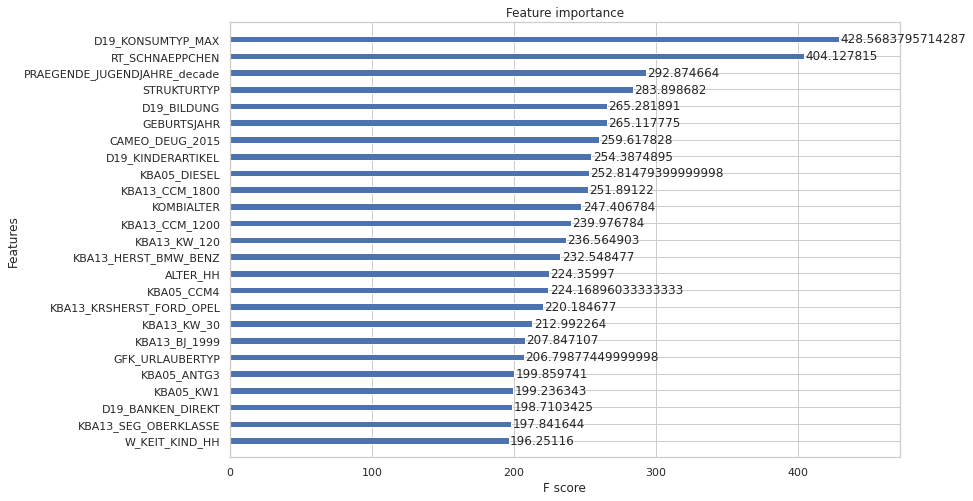

In [140]:
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xgb_clf, max_num_features=25, importance_type='gain', height=0.4, ax=ax)
plt.show()

## Prediction

In [80]:
# STORE THE Prediction in RESPONSE column
test_data['RESPONSE'] = xgb_clf.predict_proba(test_data[features])[:,1]

In [81]:
timestr = time.strftime("%Y%m%d-%H%M%S")
filename = 'prediction_'+ timestr+'.csv'
filename

'prediction_20211225-135727.csv'

In [82]:
# save the submission file with current timestamp to keep track of the files
test_data[['LNR', 'RESPONSE']].to_csv(filename, index=False)

# Kaggle Submission

In [85]:
# kaggle_df = pd.read_csv('prediction_20211211-092148.csv')

In [87]:
kaggle_df = pd.read_csv('prediction_20211225-135727.csv')

<span style="font-family: Arial; font-weight:bold;font-size:1.5em">   We have uploaded this prediction file and got the 0.72 AUC.